In [1]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import sqlite3

import os, argparse, path_config, shutil, pickle
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from loguru import logger

logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

import torch
from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from graph_GRU._multimodal_model_gru.GAT import GATClassifier as TopicProxyGRUGAT, GATJKClassifier as TopicProxyGRUGAT_V2
from graph_GRU.graph_construct import GraphConfig
from graph_GRU.multimodal_topic_gru_proxy.dataset import TopicProxyGRU_GC

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

c:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logger.remove()
logger.add(
  sys.stdout,
  colorize=True,
  format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
)

V1_MODEL = {
  'multimodal_topic_gru_proxy':TopicProxyGRUGAT
}

V2_MODEL = {
  'multimodal_topic_gru_proxy':TopicProxyGRUGAT_V2
}

MAKE_GRAPH = {
  'multimodal_topic_gru_proxy':TopicProxyGRU_GC
}

In [4]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

In [5]:
model_dir = 'checkpoints_optuna4'
model_dir_ = 'multimodal_topic_gru_proxy_v2(15s_sum_tt_conn)'
save_dir = 'graph_visualization'
save_dir_ = 'multimodal_topic_gru_proxy_v2_id_405_ipynb'
id = 405
mode = 'multimodal_topic_gru_proxy'
version = 2

best_model_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'best_model.pth')
db_path = os.path.join(path_config.ROOT_DIR, model_dir, model_dir_, 'logs', 'optuna_study.db')
assert os.path.exists(best_model_path) and os.path.exists(db_path), logger.error("Model path is wrong. Try again.")

In [6]:
logger.info(f"Processing data (Mode: {mode}, Id: {id})")

graph_config = GraphConfig(
  model_name='sentence-transformers/all-MiniLM-L6-v2',
  time_interval=15,
  use_summary_node=True,
  colab_path=None,
  explanation=True
)

gc = TopicProxyGRU_GC()

graphs, dim_list, extras = gc.make_graph(
  ids = [id],
  labels = [1],
  config = graph_config
)

t_dim = dim_list[0]
v_dim = dim_list[1]
a_dim = dim_list[2]

00:36:15 | INFO     | Processing data (Mode: multimodal_topic_gru_proxy, Id: 405)
00:36:15 | INFO     | Getting your model
00:36:19 | INFO     | Model loaded
00:36:19 | INFO     | Switching CSV into Graphs


Dataframe -> Graph: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


In [7]:
topic_node_id, utterances, vision_input, audio_input, start_stop_list = extras

best_hyperparams_dict, best_f1 = fetch_from_db(db_path)

logger.info(f"Best Params")
for k, v in best_hyperparams_dict.items():
  logger.info(f"  - {k}: {v}")
logger.info(f"=> F1-score: {best_f1}")

00:36:21 | INFO     | Best Params
00:36:21 | INFO     |   - a_dropout: 0.2900622904259149
00:36:21 | INFO     |   - g_dropout: 0.25800526423614906
00:36:21 | INFO     |   - gru_num_layers: 1.0
00:36:21 | INFO     |   - num_layers: 4
00:36:21 | INFO     |   - t_dropout: 0.2953545187684425
00:36:21 | INFO     |   - use_attention: True
00:36:21 | INFO     |   - use_text_proj: False
00:36:21 | INFO     |   - v_dropout: 0.20080493231878216
00:36:21 | INFO     | => F1-score: 0.8125


In [8]:
logger.info("==============================")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Loading your model (Device: {device})")

assert version in [1,2], logger.error("Version should be int type 1 or 2")

if version == 2:
  model_dict = V2_MODEL
else:
  model_dict = V1_MODEL

dropout_dict = {
  'text_dropout':best_hyperparams_dict.get('t_dropout', 0.0),
  'graph_dropout':best_hyperparams_dict.get('g_dropout', 0.0),
  'vision_dropout':best_hyperparams_dict.get('v_dropout', 0.0),
  'audio_dropout':best_hyperparams_dict.get('a_dropout', 0.0)
}


model = model_dict[mode](
  text_dim=t_dim,
  vision_dim=v_dim,
  audio_dim=a_dim,
  hidden_channels=256 if best_hyperparams_dict['use_text_proj'] else t_dim,
  num_layers=int(best_hyperparams_dict['num_layers']),
  gru_num_layers=int(best_hyperparams_dict['gru_num_layers']),
  num_classes=2,
  dropout_dict=dropout_dict,
  heads=8,
  use_attention=best_hyperparams_dict['use_attention'],
  use_summary_node=True,
  use_text_proj=best_hyperparams_dict['use_text_proj']
).to(device)

best_model_state_dict = torch.load(best_model_path)
model.load_state_dict(best_model_state_dict)

00:36:21 | INFO     | ==============================
00:36:21 | INFO     | Loading your model (Device: cuda)


<All keys matched successfully>

In [9]:
sample_loader = DataLoader(graphs)

model.eval()
with torch.no_grad():
  for data in sample_loader:
    data = data.to(device)
    result, x, flat_node_types = model(data, explanation=True)
    x = x.cpu()

logger.info(f"Result: {int(torch.sigmoid(result) > 0.5)}")

00:36:22 | INFO     | Result: 1


In [10]:
topic_node_id

{'개인 특성 및 취미': 0,
 '경력, 교육 및 군 복무': 1,
 '대인 관계 및 가족': 2,
 '생활 환경': 3,
 '심리 상태 및 감정': 4}

In [11]:
topic_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'topic']
text_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'transcription']
proxy_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'proxy']
vision_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'vision']
audio_indices = [i for i, v in enumerate(graphs[0].node_types) if v == 'audio']

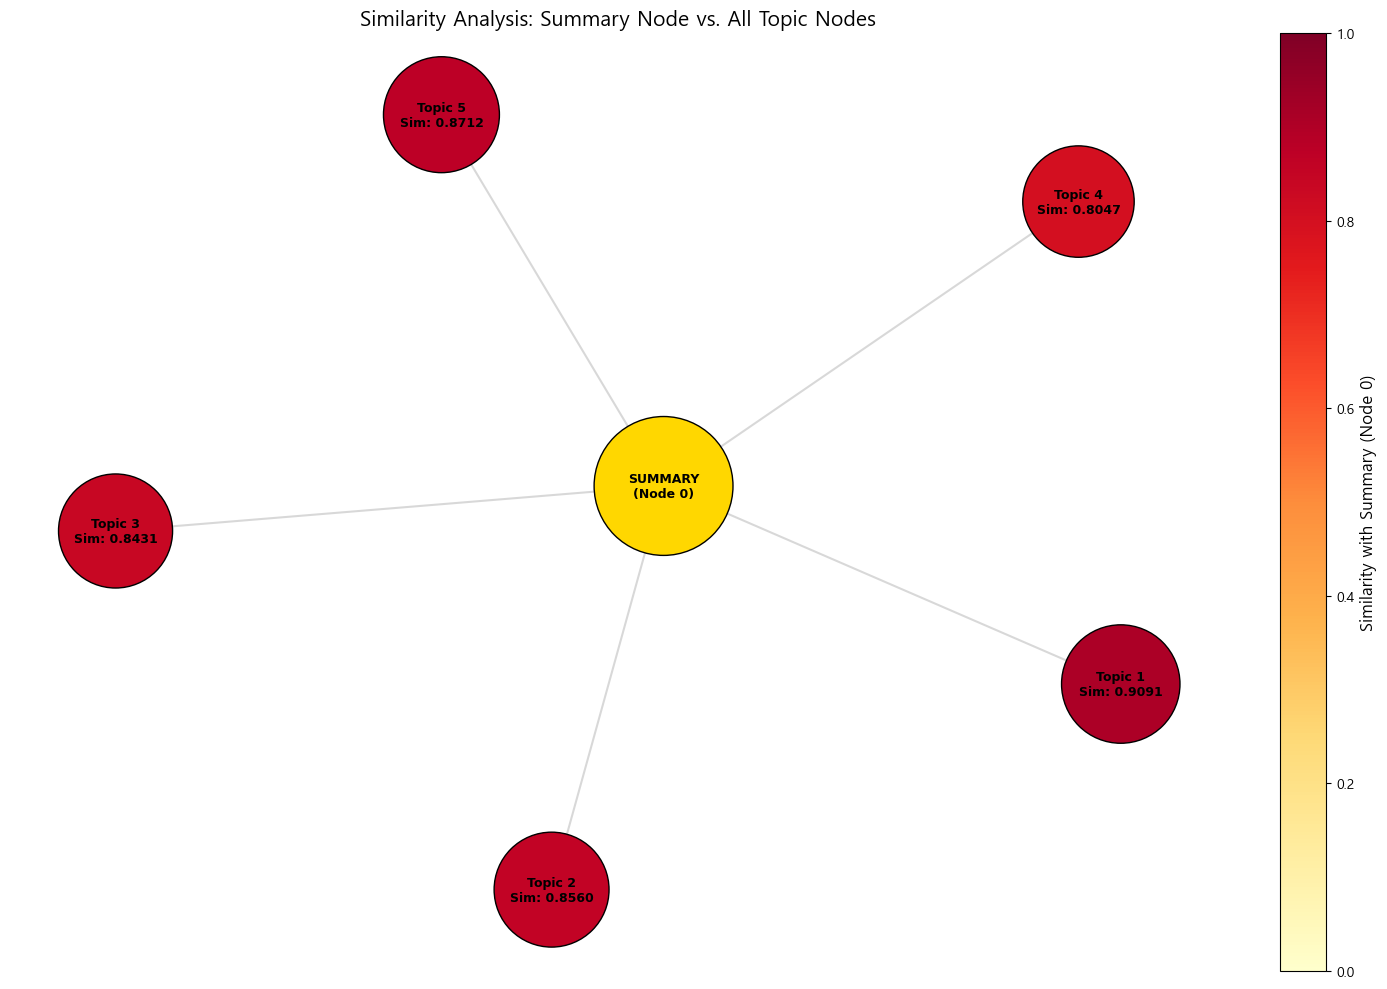

In [12]:
def visualize_summary_vs_all_topics(data, all_topic_indices, summary_node_idx=0, topic_labels=None):
  """
  Summary 노드와 모든 Topic 노드 간 유사도 비교
  """
  edge_index = data.edge_index

  nodes_to_viz = [summary_node_idx] + list(all_topic_indices)
  nodes_to_viz = sorted(list(set(nodes_to_viz)))

  summary_vec = data.x[summary_node_idx].unsqueeze(0)
  topic_vecs = data.x[all_topic_indices]

  similarities = F.cosine_similarity(summary_vec, topic_vecs).cpu().detach().numpy()
  sim_dict = {idx: sim for idx, sim in zip(all_topic_indices, similarities)}

  G = nx.Graph()
  G.add_nodes_from(nodes_to_viz)

  # 엣지 추가: Summary 노드(0번)와 연결된 토픽 노드들만 연결 (Star Graph 형태)
  edge_list = edge_index.t().tolist()
  viz_set = set(nodes_to_viz)
  for u, v in edge_list:
    # print(u, v) # 필요 시 주석 해제
    if u == summary_node_idx and v in viz_set:
      G.add_edge(u, v)
    elif v == summary_node_idx and u in viz_set:
      G.add_edge(u, v)

  # 4. 시각화 설정
  plt.figure(figsize=(14, 10))

  # 레이아웃: summary 노드와의 유사도를 edge weight로 활용하여 배치 유도
  for u, v in G.edges():
    if u == summary_node_idx or v == summary_node_idx:
      topic_idx = v if u == summary_node_idx else u
      G[u][v]['weight'] = sim_dict.get(topic_idx, 0.5) * 5
    else:
      G[u][v]['weight'] = 1.0

  pos = nx.spring_layout(G, k=1.0, weight='weight', seed=42)

  node_colors = []
  node_sizes = []
  labels = {}

  for node_idx in nodes_to_viz:
    if node_idx == summary_node_idx:
      node_colors.append('gold')
      node_sizes.append(10000)
      labels[node_idx] = "SUMMARY\n(Node 0)"
    else:
      sim = sim_dict.get(node_idx, 0)
      node_colors.append(plt.cm.YlOrRd(sim)) # 유사도에 따라 노란색->빨간색
      node_sizes.append(max(2000, sim * 8000))

      # 토픽 라벨 이름이 있으면 출력
      display_name = topic_labels.get(node_idx, f"Topic {node_idx}") if topic_labels else f"Topic {node_idx}"
      labels[node_idx] = f"{display_name}\nSim: {sim:.4f}"

  # 5. 그리기
  nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', width=1.5)

  nx.draw_networkx_nodes(G, pos,
                         node_color=node_colors,
                         node_size=node_sizes,
                         edgecolors='black',
                         linewidths=1)

  nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold')

  # 컬러바 추가
  sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=1))
  sm.set_array([])
  cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.046, pad=0.04)
  cbar.set_label('Similarity with Summary (Node 0)', fontsize=12)

  plt.title("Similarity Analysis: Summary Node vs. All Topic Nodes", fontsize=15)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

# 사용 예시
all_topic_nodes = [i for i, t in enumerate(graphs[0].node_types) if t == 'topic']
visualize_summary_vs_all_topics(graphs[0], all_topic_nodes)

In [12]:
source_indices = graphs[0].edge_index[0].numpy()
target_indices = graphs[0].edge_index[1].numpy()

In [13]:
utterances, vision_input, audio_input = np.array(utterances), np.array(vision_input), np.array(audio_input)

In [14]:
# For the fist topic
topic_target_indices = np.where(target_indices==topic_indices[2])                         # extract index of target edge_index where target is the certain topic node
text_source_ids = source_indices[topic_target_indices]                                    # extract text node ids from source edge_index
text_valid_ids = text_source_ids[text_source_ids>len(topic_indices)]                      # delete topic node ids
topic_text_indices = np.where(np.isin(text_indices, text_valid_ids)==True)                # extract text(utterance) index from text indices
topic_utterances = utterances[topic_text_indices]

text_target_indices = np.where(np.isin(target_indices, text_valid_ids)==True)             # extract index of target edge_index where target is the text from first topic node
proxy_source_ids = source_indices[text_target_indices]                                    # extract proxy node ids from source edge_index

proxy_target_indices = np.where(np.isin(target_indices, proxy_source_ids)==True)          # extract index of target edge_index where target is the proxy from text
vision_audio_source_ids = source_indices[proxy_target_indices]                            # extract vision/audio node ids from source edge_index
topic_vision_indices = np.where(np.isin(vision_indices, vision_audio_source_ids)==True)   # extract vision index from vision indices
topic_audio_indices = np.where(np.isin(audio_indices, vision_audio_source_ids)==True)     # extract audio index from vision indices
topic_vision = vision_input[topic_vision_indices]
topic_audio = vision_input[topic_audio_indices]

In [15]:
topic_node_dict = {v+1:str(k) for k,v in topic_node_id.items()}

In [16]:
text_valid_ids

array([ 86,  90,  94,  98, 102, 106, 110, 114, 118, 122, 126, 130, 134,
       138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182],
      dtype=int64)

In [17]:
topic_utterances

array(["hm. probably with my. husband. and. i can't remember at the moment what it was about.",
       'um well when you say my family do you mean. my  family from childhood or my current family.',
       "okay well i guess my current family comes to mind i i have two daughters. and. my relationship's pretty good it's okay with them but they're teenagers which uh. you know.  going they're going through a lot of hormones and",
       "um. they can be kinda bitchy <laughter> and. and um but i have hoped that you know they'll grow out of that and soon someday we'll have a really good relationship.  um and then there's the husband which",
       "i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah.  yeah so that that's not good the",
       "the relationship with the husband but um. but since we have determined that we need to divorce.  our our we don't expect anything out out of each 

In [18]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain import Explainer, GNNExplainer
from captum.attr import IntegratedGradients
from tqdm import tqdm
import time

"""
=============================================================================
GNN Explainer 진행 과정 모니터링 버전
=============================================================================
"""

class ProgressGNNExplainer(GNNExplainer):
    """진행 상황을 출력하고, 마스크 초기화 안전장치를 포함한 GNN Explainer"""
    def __init__(self, epochs=100, **kwargs):
        super().__init__(epochs=epochs, **kwargs)
        self.loss_history = []
    
    def _train(self, model, x, edge_index, *, target, index, **kwargs):
        """학습 과정에서 진행 상황 출력 및 마스크 강제 초기화"""
        
        # 1. 마스크가 없는 경우 생성 (기존 로직)
        if self.node_mask is None and self.edge_mask is None:
            self._initialize_masks(x, edge_index)

        # 2. [필수] 마스크 값을 1.0(모두 중요함)으로 초기화하여 Gradient 소실 방지
        if self.edge_mask is not None:
            torch.nn.init.constant_(self.edge_mask, 1.0) 
        if self.node_mask is not None:
            torch.nn.init.constant_(self.node_mask, 1.0)

        # 3. Optimizer 설정
        parameters = []
        if self.node_mask is not None:
            parameters.append(self.node_mask)
        if self.edge_mask is not None:
            parameters.append(self.edge_mask)
            
        if len(parameters) == 0:
            raise ValueError("No masks to optimize! Check Explainer config.")

        self.optimizer = torch.optim.AdamW(parameters, lr=self.lr)
        
        # 4. 학습 루프
        pbar = tqdm(range(self.epochs), desc="Training GNN Explainer")
        for epoch in pbar:
            self.optimizer.zero_grad()

            # node_mask는 학습 파라미터이므로 sigmoid를 통과시켜 0~1 사이 값으로 만듦
            masked_x = x * self.node_mask.sigmoid()
            
            if self.edge_mask is not None:
                pass

            # 모델에 '원본 x'가 아니라 '마스킹된 x'를 넣어야 함
            h = model(masked_x, edge_index, **kwargs)
            
            loss = self._loss(h, target)
            loss.backward()
            self.optimizer.step()
            
            self.loss_history.append(loss.item())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})


class ModelWrapper(torch.nn.Module):
    def __init__(self, model, base_data):
        super().__init__()
        self.model = model
        self.base_data = base_data
    
    def forward(self, x, edge_index, **kwargs):
        data = self.base_data.clone()
        data.x = x
        data.edge_index = edge_index
        
        # 필수 속성들 복사
        data.x_vision = self.base_data.x_vision
        data.x_audio = self.base_data.x_audio
        data.vision_lengths = self.base_data.vision_lengths
        data.audio_lengths = self.base_data.audio_lengths
        data.node_types = self.base_data.node_types
        
        # ptr 속성 추가 (단일 그래프용)
        if not hasattr(data, 'ptr'):
            data.ptr = torch.tensor([0, data.x.size(0)], dtype=torch.long, device=x.device)
        
        # batch 속성 확인
        if not hasattr(data, 'batch'):
            data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=x.device)
        
        return self.model(data, explanation=False)


def explain_with_gnn_explainer_verbose(model, data, target_topic, all_topics, epochs=100):
    """
    진행 상황을 자세히 출력하는 GNN Explainer
    
    Args:
        model: 학습된 GNN 모델
        data: PyG Data 객체
        target_topic: 타겟 토픽 노드 ID
        all_topics: 모든 토픽 노드 리스트
        epochs: Explainer 학습 에폭 수
    """
    device = data.x.device
    model.eval()
    
    print(f"\n{'='*70}")
    print(f"🎯 Target Topic: {target_topic}")
    print(f"📊 Graph Info: {data.num_nodes} nodes, {data.num_edges} edges")
    print('='*70)
    
    # 배치 정보 추가
    if not hasattr(data, 'batch'):
        data.batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    
    # ptr 속성 추가 (중요!)
    if not hasattr(data, 'ptr'):
        data.ptr = torch.tensor([0, data.x.size(0)], dtype=torch.long, device=device)
        print("✅ Added 'ptr' attribute for single graph")
    
    # 모델 래퍼 생성
    wrapped_model = ModelWrapper(model, data).to(device)
    
    try:
        start_time = time.time()
        
        # Progress GNN Explainer 사용
        explainer = Explainer(
            model=wrapped_model,
            algorithm=ProgressGNNExplainer(
                epochs=epochs,
                lr=0.03,
                node_alpha=0.01, # 노드 마스크를 더 짜게(Sparse)
                edge_alpha=0.05, # 엣지 마스크를 더 짜게(Sparse)
            ),
            explanation_type='model',
            node_mask_type='object',
            edge_mask_type='object',
            model_config=dict(
                mode='binary_classification',
                task_level='graph',
                return_type='raw',
            ),
        )
        
        # 설명 생성
        print("\n⏳ Generating explanation...")
        with torch.backends.cudnn.flags(enabled=False):
            explanation = explainer(data.x, data.edge_index, batch=data.batch)
        
        elapsed = time.time() - start_time
        print(f"\n⏱️  Total Time: {elapsed:.2f} seconds")
        
        # 결과 요약
        raw_mask = explanation.node_mask.detach()
        prob_mask = raw_mask.sigmoid()

        node_importance = prob_mask.mean(dim=1).cpu().numpy()

        print("\n📈 Explanation Statistics (Probabilities):")
        print(f"  Node importance - Mean: {node_importance.mean():.4f}")
        print(f"  Node importance - Max:  {node_importance.max():.4f}")
        print(f"  Node importance - Min:  {node_importance.min():.4f}")
        
        return explanation, explainer.algorithm.loss_history
        
    except Exception as e:
        print(f"\n❌ GNNExplainer failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None
    
def plot_loss_curve(loss_history):
    """GNN Explainer의 손실 곡선 시각화"""
    if loss_history is None or len(loss_history) == 0:
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, linewidth=2, color='#4ECDC4')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('GNN Explainer Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def compare_all_methods(model, data, target_topic, all_topics):
    """
    모든 설명 방법을 비교하고 시간 측정
    """
    device = data.x.device
    model.eval()
    
    results = {}
    timings = {}
    
    print(f"\n{'='*70}")
    print("🔬 COMPARING ALL EXPLANATION METHODS")
    print('='*70)
    
    # 1. SIMPLE
    print("\n[1/4] 🚀 SIMPLE (Input Feature Similarity)")
    start = time.time()
    node_attr, edge_attr = explain_simple(model, data, target_topic)
    timings['simple'] = time.time() - start
    results['simple'] = (node_attr, edge_attr, "SIMPLE")
    print(f"  ✅ Completed in {timings['simple']:.3f}s")
    
    # 2. COSINE
    print("\n[2/4] 🧮 COSINE (Model Embedding Similarity)")
    start = time.time()
    node_attr, edge_attr, _ = explain_with_model_embeddings(model, data, target_topic)
    timings['cosine'] = time.time() - start
    results['cosine'] = (node_attr, edge_attr, "COSINE")
    print(f"  ✅ Completed in {timings['cosine']:.3f}s")
    
    # 3. GRADIENT
    print("\n[3/4] 📉 GRADIENT (Captum IntegratedGradients)")
    start = time.time()
    try:
        node_attr, edge_attr, _ = explain_with_gradients(model, data, target_topic)
        timings['gradient'] = time.time() - start
        results['gradient'] = (node_attr, edge_attr, "GRADIENT")
        print(f"  ✅ Completed in {timings['gradient']:.3f}s")
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        timings['gradient'] = None
    
    # 4. GNN_EXPLAINER
    print("\n[4/4] 🎯 GNN_EXPLAINER (Structure + Features)")
    start = time.time()
    explanation, loss_history = explain_with_gnn_explainer_verbose(
        model, data, target_topic, all_topics, epochs=300
    )
    timings['gnn'] = time.time() - start
    
    if explanation is not None:
        node_attr = explanation.node_mask.sum(dim=1).detach().cpu().numpy()
        edge_attr = explanation.edge_mask.detach().cpu().numpy()
        results['gnn'] = (node_attr, edge_attr, "GNN_EXPLAINER")

        plot_loss_curve(loss_history)
    
    # 시간 비교
    print(f"\n{'='*70}")
    print("⏱️  EXECUTION TIME COMPARISON")
    print('='*70)
    for method, t in timings.items():
        if t is not None:
            print(f"  {method.upper():15s}: {t:6.3f}s")
    print('='*70)
    
    return results, timings


def explain_simple(model, data, target_topic):
    """간단한 입력 피처 기반 설명"""
    target_feature = data.x[target_topic].unsqueeze(0)
    node_attr = F.cosine_similarity(target_feature, data.x).cpu().numpy()
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr


def explain_with_model_embeddings(model, data, target_topic):
    """모델 임베딩 기반 설명"""
    device = data.x.device
    model.eval()
    
    with torch.no_grad():
        x, edge_index = data.x, data.edge_index
        node_types = data.node_types
        
        # Text projection
        if hasattr(model, 'use_text_proj') and model.use_text_proj:
            x = model.text_proj(x)
        x = model.dropout_text(x)
        
        # Vision/Audio 처리 (GAT.py와 동일하게)
        flat_node_types = []
        if isinstance(node_types[0], list):
            for sublist in node_types: 
                flat_node_types.extend(sublist)
        else:
            flat_node_types = node_types
        
        vision_indices = [i for i, t in enumerate(flat_node_types) if t == 'vision']
        audio_indices = [i for i, t in enumerate(flat_node_types) if t == 'audio']
        
        # Vision GRU
        if data.x_vision.size(0) > 0 and len(vision_indices) > 0:
            h_vision, _ = model.vision_gru(data.x_vision, data.vision_lengths)
            if len(vision_indices) == h_vision.size(0):
                x[vision_indices] = h_vision.to(x.dtype)
        
        # Audio GRU
        if data.x_audio.size(0) > 0 and len(audio_indices) > 0:
            h_audio, _ = model.audio_gru(data.x_audio, data.audio_lengths)
            if len(audio_indices) == h_audio.size(0):
                x[audio_indices] = h_audio.to(x.dtype)
        
        # GAT layers (num_layers에 따라)
        x = F.dropout(x, p=model.dropout_g, training=False)
        x = model.conv1(x, edge_index)
        x = model.norm1(x)
        x = F.elu(x)
        
        if model.num_layers >= 3:
            x_in = x
            x = F.dropout(x, p=model.dropout_g, training=False)
            x = model.conv2(x, edge_index)
            x = model.norm2(x + x_in) if hasattr(model, 'norm2') else x
            x = F.elu(x)
        
        if model.num_layers >= 4:
            x_in = x
            x = F.dropout(x, p=model.dropout_g, training=False)
            x = model.conv3(x, edge_index)
            x = model.norm3(x + x_in) if hasattr(model, 'norm3') else x
            x = F.elu(x)
        
        x = F.dropout(x, p=model.dropout_g, training=False)
        x = model.conv4(x, edge_index)
        x = model.norm4(x)
        
        target_emb = x[target_topic].unsqueeze(0)
        node_attr = F.cosine_similarity(target_emb, x).cpu().numpy()
    
    edge_index = data.edge_index
    src_sim = node_attr[edge_index[0].cpu()]
    dst_sim = node_attr[edge_index[1].cpu()]
    edge_attr = (src_sim + dst_sim) / 2
    
    return node_attr, edge_attr, "Model Embedding"


def explain_with_gradients(model, data, target_topic):
    """Gradient 기반 설명"""
    device = data.x.device
    model.eval()
    
    def forward_func(node_features):
        data_copy = data.clone()
        data_copy.x = node_features
        
        # 필수 속성 복사
        data_copy.x_vision = data.x_vision
        data_copy.x_audio = data.x_audio
        data_copy.vision_lengths = data.vision_lengths
        data_copy.audio_lengths = data.audio_lengths
        data_copy.node_types = data.node_types
        
        # batch와 ptr 추가
        if not hasattr(data_copy, 'batch'):
            data_copy.batch = torch.zeros(data_copy.x.size(0), dtype=torch.long, device=device)
        if not hasattr(data_copy, 'ptr'):
            data_copy.ptr = torch.tensor([0, data_copy.x.size(0)], dtype=torch.long, device=device)
        
        out = model(data_copy, explanation=False)
        if out.dim() == 1:
            out = out.unsqueeze(-1)
        return out

    ig = IntegratedGradients(forward_func)
    baseline_x = torch.zeros_like(data.x)
    
    attributions = ig.attribute(
        data.x,
        baselines=baseline_x,
        target=0,
        n_steps=50,
        internal_batch_size=1
    )
    
    node_attr = attributions.abs().sum(dim=1).cpu().detach().numpy()
    target_importance = node_attr[target_topic]
    node_attr = node_attr / (target_importance + 1e-8)
    
    edge_index = data.edge_index
    src_imp = node_attr[edge_index[0].cpu()]
    dst_imp = node_attr[edge_index[1].cpu()]
    edge_attr = (src_imp + dst_imp) / 2
    
    return node_attr, edge_attr, "Gradient"

In [19]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def visualize_topic_subgraph(data, node_attr, edge_attr, target_topic_idx, title="Topic Subgraph Visualization"):
  """
  중요도(node_attr)에 따른 투명도 조절 기능을 유지하며, 엣지 소실 문제를 해결한 버전입니다.
  """
  # 1. 데이터 준비 및 레이어 분리
  edge_index = data.edge_index.cpu().numpy()
  src, dst = edge_index[0], edge_index[1]

  flat_node_types = []
  if isinstance(data.node_types[0], list):
    for sublist in data.node_types: flat_node_types.extend(sublist)
  else:
    flat_node_types = data.node_types
  flat_node_types = np.array(flat_node_types)

  l0 = [target_topic_idx]
  l1 = sorted(list(set([v if u == target_topic_idx else u for u, v in zip(src, dst)
                 if (u == target_topic_idx or v == target_topic_idx) and flat_node_types[v if u == target_topic_idx else u] == 'transcription'])))
  l2 = []
  if l1:
    l2 = sorted(list(set([v if u in l1 else u for u, v in zip(src, dst)
                   if (u in l1 or v in l1) and flat_node_types[v if u in l1 else u] == 'proxy'])))
  l3 = []
  if l2:
    l3 = sorted(list(set([v if u in l2 else u for u, v in zip(src, dst)
                   if (u in l2 or v in l2) and flat_node_types[v if u in l2 else u] in ['vision', 'audio']])))

  all_nodes = list(set(l0 + l1 + l2 + l3))
  G = nx.DiGraph() # 방향성 그래프 생성

  # 2. Barycenter 정렬 (교차 최소화)
  adj_map = {n: [] for n in all_nodes}
  for u, v in zip(src, dst):
    if u in all_nodes and v in all_nodes:
      adj_map[u].append(v); adj_map[v].append(u)

  ordered_layers = [l0]
  for curr_raw_layer, prev_sorted_layer in [(l1, l0), (l2, l1), (l3, l2)]:
    if not curr_raw_layer:
      ordered_layers.append([])
      continue
    node_scores_order = {}
    for node in curr_raw_layer:
      parents = [p for p in adj_map[node] if p in prev_sorted_layer]
      node_scores_order[node] = np.mean([prev_sorted_layer.index(p) for p in parents]) if parents else 0
    sorted_layer = sorted(curr_raw_layer, key=lambda x: node_scores_order.get(x, 0))
    ordered_layers.append(sorted_layer)
    if prev_sorted_layer == l0: l1 = sorted_layer
    elif prev_sorted_layer == l1: l2 = sorted_layer

  # 3. 좌표 설정 및 그래프 구성 (엣지 추가 포함)
  pos = {}
  x_spread, y_step = 20.0, 3.0
  for l_idx, nodes in enumerate(ordered_layers):
    for n_idx, node in enumerate(nodes):
      pos[node] = np.array([(n_idx - (len(nodes) - 1) / 2) * x_spread, -l_idx * y_step])
      G.add_node(node) # 노드 추가

  # 엣지 추가: 원본 데이터 방향과 관계없이 레이어 위 -> 아래로 강제 연결
  for i, (u, v) in enumerate(zip(src, dst)):
    if u in all_nodes and v in all_nodes:
      u_l = next((idx for idx, layer in enumerate(ordered_layers) if u in layer), None)
      v_l = next((idx for idx, layer in enumerate(ordered_layers) if v in layer), None)

      if u_l is not None and v_l is not None and u_l != v_l:
        # 무조건 레이어 번호가 작은 곳에서 큰 곳으로 화살표 방향 설정
        parent, child = (u, v) if u_l < v_l else (v, u)
        w = float(np.clip(edge_attr[i] if edge_attr is not None else 0.5, 0.0, 1.0))
        G.add_edge(parent, child, weight=w)

  # 4. 중요도 정규화 (투명도용)
  viz_scores = node_attr[all_nodes]
  min_s, max_s = viz_scores.min(), viz_scores.max()

  def get_alpha(score):
    if max_s == min_s: return 1.0
    return 0.4 + 0.6 * (score - min_s) / (max_s - min_s + 1e-9)

  # 5. 시각화
  plt.figure(figsize=(50, 14))
  plt.gca().set_facecolor('white')
  plt.gcf().set_facecolor('white')

  color_map = {'summary': '#FF6B6B', 'topic': '#4ECDC4', 'transcription': '#45B7D1', 'proxy': '#A0A0A0', 'vision': '#FFA07A', 'audio': '#98D8C8'}

  # 엣지 그리기: G.edges() 데이터 활용
  for u, v, d in G.edges(data=True):
    w = d['weight']
    alpha_edge = max(0.3, w)
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                           width=2 + 6 * w, edge_color='#444444',
                           alpha=0.2, arrowstyle='-|>', arrowsize=25)

  # 노드 및 라벨 그리기 (개별 투명도 적용)
  for node in all_nodes:
    n_type = flat_node_types[node]
    score = node_attr[node]
    alpha_val = float(get_alpha(score))

    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color=[color_map.get(n_type, 'gray')],
                           node_size=9000 if node == target_topic_idx else 4500,
                           alpha=alpha_val,
                           edgecolors='black', linewidths=1.2)

    nx.draw_networkx_labels(G, pos,
                            labels={node: f"{node}\n({score:.3f})"},
                            font_size=15,
                            font_color='black',
                            font_weight='bold',
                            alpha=alpha_val)

  plt.title(title, fontsize=22, color='black', pad=30)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

In [20]:
def visualize_summary_topic_explanation(data, node_attr, edge_attr, all_topic_indices, topic_labels, summary_node_idx=0, title="Graph Visualization: Topic Relevance to Summary (ID: 405)"):
  """
  제공된 이미지 스타일로 Summary와 Topic 관계를 시각화함.
  topic_labels: {node_idx: "토픽명"} 형태의 딕셔너리
  """
  nodes_to_viz = [summary_node_idx] + list(all_topic_indices)
  G = nx.Graph()

  node_scores = node_attr.cpu().detach().numpy() if torch.is_tensor(node_attr) else node_attr

  for node_idx in nodes_to_viz:
    G.add_node(node_idx)

  # 2. 엣지 추가 (Summary와 각 Topic 연결)
  edge_weights = edge_attr.cpu().detach().numpy() if torch.is_tensor(edge_attr) else edge_attr
  edge_index = data.edge_index.cpu().numpy()

  for i in range(len(edge_index[0])):
    u, v = edge_index[0][i], edge_index[1][i]
    if (u == summary_node_idx and v in all_topic_indices) or (v == summary_node_idx and u in all_topic_indices):
      G.add_edge(u, v)

  pos = nx.shell_layout(G, [ [summary_node_idx], list(all_topic_indices) ])

  plt.figure(figsize=(12, 12))
  plt.gca().set_facecolor('white')

  color_summary = '#FF7F7F'
  color_topic = '#7EDAD4'

  node_colors = [color_summary if n == summary_node_idx else color_topic for n in G.nodes()]
  nx.draw_networkx_nodes(G, pos, node_size=8000, node_color=node_colors, alpha=0.9)

  nx.draw_networkx_edges(G, pos, width=1.0, edge_color='#CCCCCC', alpha=0.8)

  labels = {}
  for n in G.nodes:
    score = node_scores[n]
    if n == summary_node_idx:
      labels[n] = "Summary"
    else:
      label_text = topic_labels.get(n, f"Topic {n}")
      labels[n] = f"{label_text}\n-> {score:.4f}"

  nx.draw_networkx_labels(G, pos, labels=labels, font_size=11, font_weight='bold', font_family=None)

  from matplotlib.patches import Patch
  legend_elements = [
    Patch(facecolor=color_summary, label='Summary'),
    Patch(facecolor=color_topic, label='Topic')
  ]
  plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

  plt.title(title, fontsize=18, pad=20)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

# 사용 예시:
# topic_names = {1: "심리 상태 및 감정", 2: "개인 특성 및 경험", 3: "대인 관계 및 가족", 4: "생활 환경 및 취미"}
# visualize_summary_topic_explanation_v2(data, node_mask, edge_mask, [1, 2, 3, 4], topic_names)

In [31]:
logger.info("Comparing all methods...")
results, timings = compare_all_methods(
   model=model,
   data=target_graph,
   target_topic=target_topic_idx,
   all_topics=all_topic_indices
)

17:56:10 | INFO     | Comparing all methods...

🔬 COMPARING ALL EXPLANATION METHODS

[1/4] 🚀 SIMPLE (Input Feature Similarity)
  ✅ Completed in 0.001s

[2/4] 🧮 COSINE (Model Embedding Similarity)
  ✅ Completed in 0.208s

[3/4] 📉 GRADIENT (Captum IntegratedGradients)


C:\Users\pegoo\anaconda3\envs\graph_env\lib\site-packages\captum\attr\_utils\batching.py:51: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 362 equal to the number of examples.
  warnings.warn(


  ✅ Completed in 2.840s

[4/4] 🎯 GNN_EXPLAINER (Structure + Features)

🎯 Target Topic: 3
📊 Graph Info: 362 nodes, 381 edges
✅ Added 'ptr' attribute for single graph

⏳ Generating explanation...


Training GNN Explainer:  12%|█████▏                                      | 35/300 [00:17<02:12,  2.01it/s, Loss=0.0002]


KeyboardInterrupt: 

In [51]:
# with open(os.path.join(path_config.ROOT_DIR, 'graph_visualization', 'multimodal_topic_gru_proxy_v2_id_405', 'analysis_result.pkl'),'wb') as fw:
#   pickle.dump(results, fw)
with open(os.path.join(path_config.ROOT_DIR, 'graph_visualization', 'multimodal_topic_gru_proxy_v2_id_405', 'analysis_result.pkl'),'rb') as fw:
  results = pickle.load(fw)

23:19:34 | INFO     | Target Graph: 362 nodes, 381 edges
23:19:34 | INFO     | Target Topic Node Index: 1

🎨 STARTING TOPIC-CENTERED VISUALIZATION FOR ALL METHODS

▶ Method: SIMPLE
  📷 Vision Importance | Avg: -0.0428, Max: -0.0428
  🎤 Audio Importance  | Avg: -0.0428, Max: -0.0428


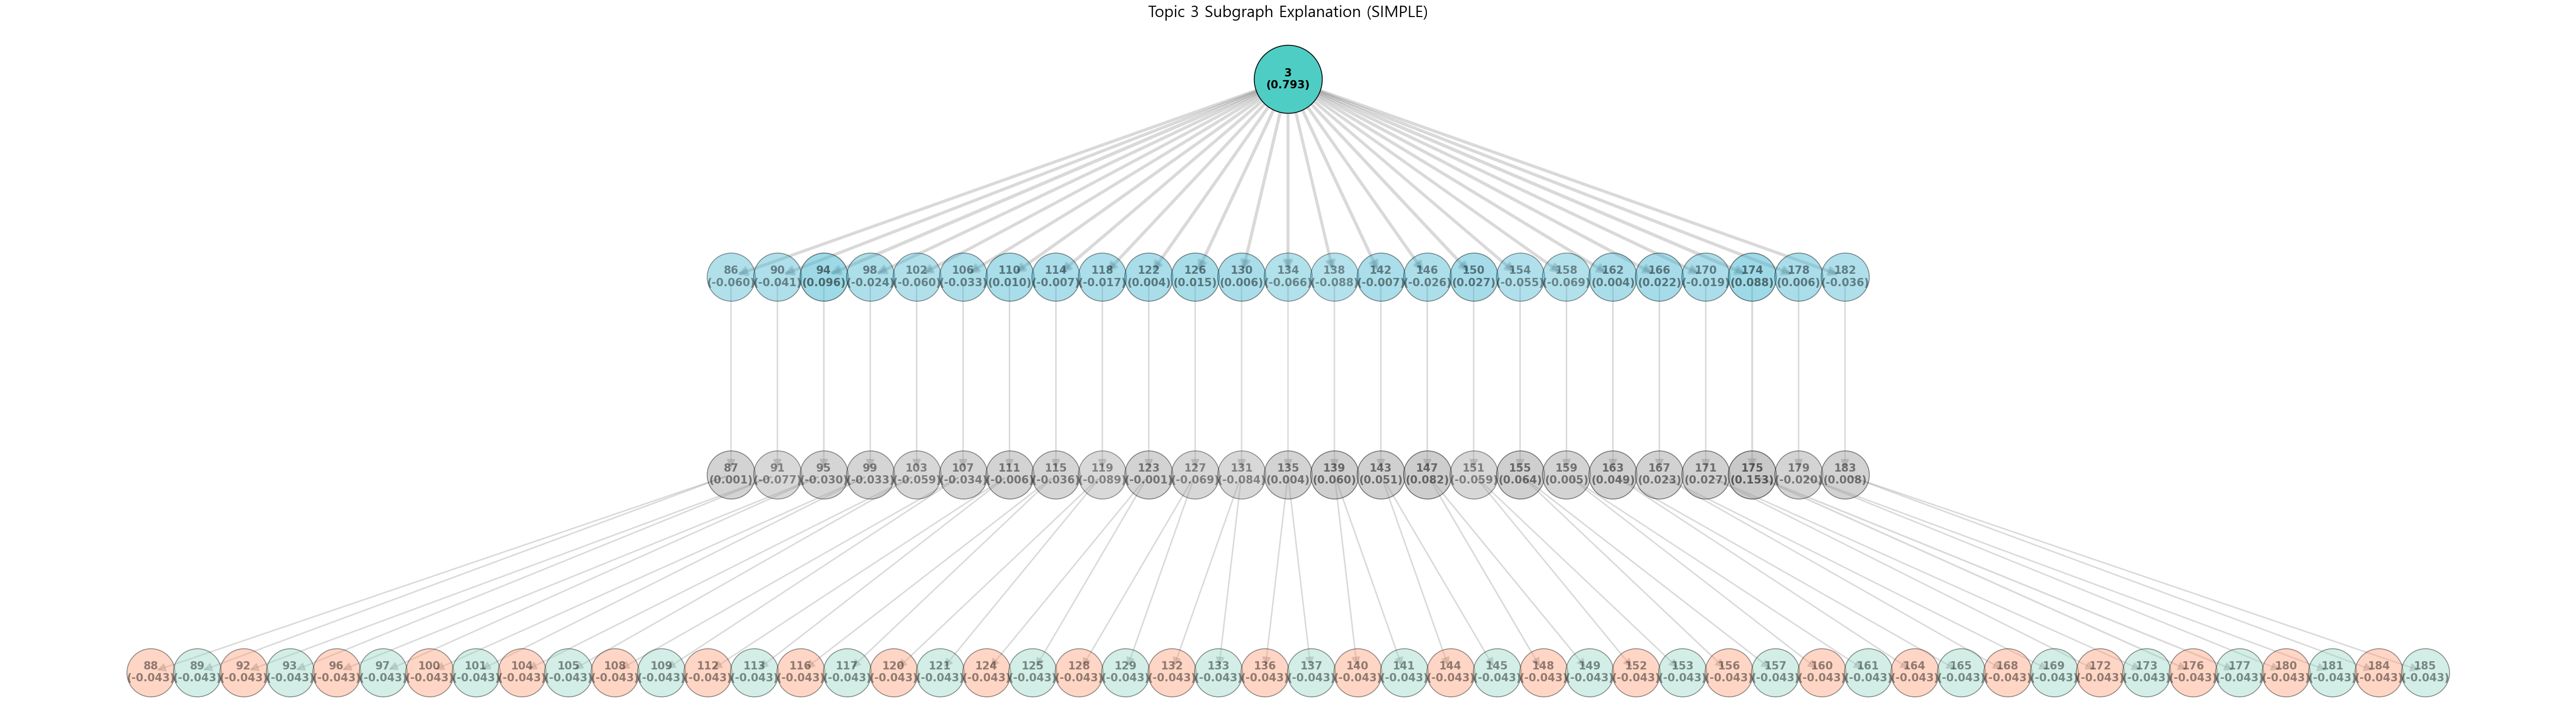

------------------------------------------------------------

▶ Method: COSINE
  📷 Vision Importance | Avg: -0.4238, Max: 0.2590
  🎤 Audio Importance  | Avg: 0.2849, Max: 0.8330


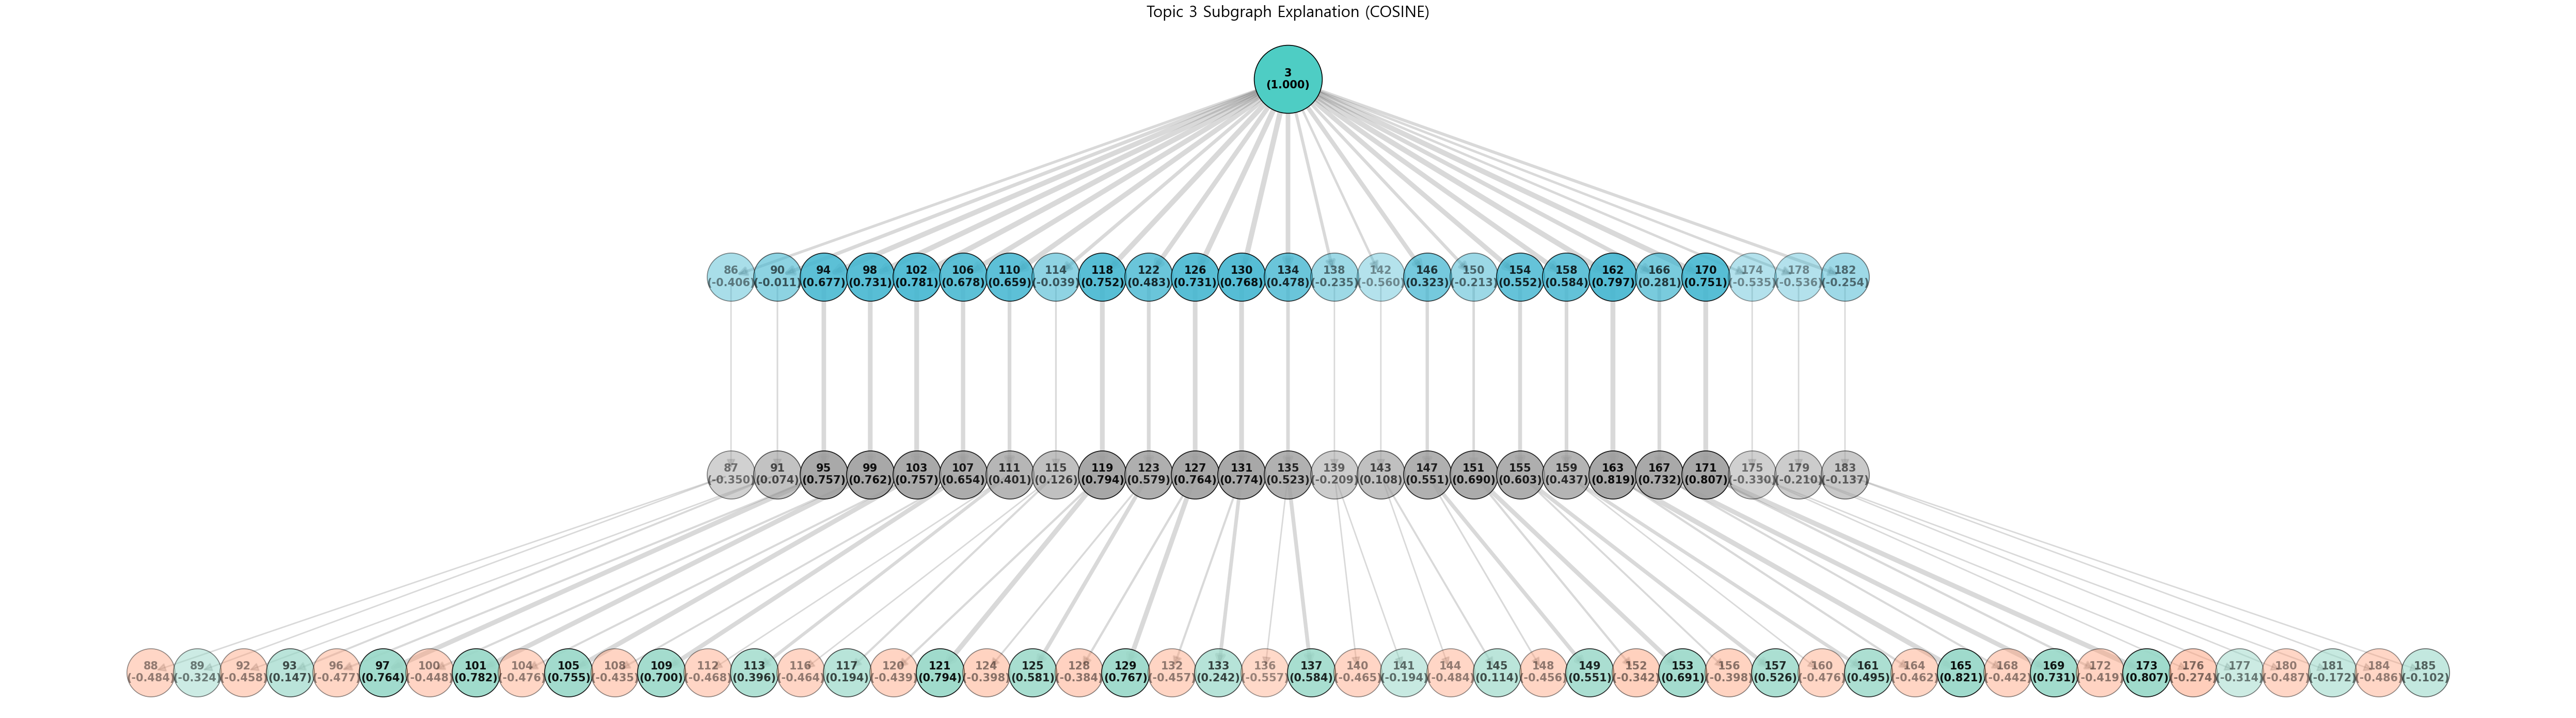

------------------------------------------------------------

▶ Method: GRADIENT
  📷 Vision Importance | Avg: 0.0257, Max: 0.2785
  🎤 Audio Importance  | Avg: 0.0001, Max: 0.0006


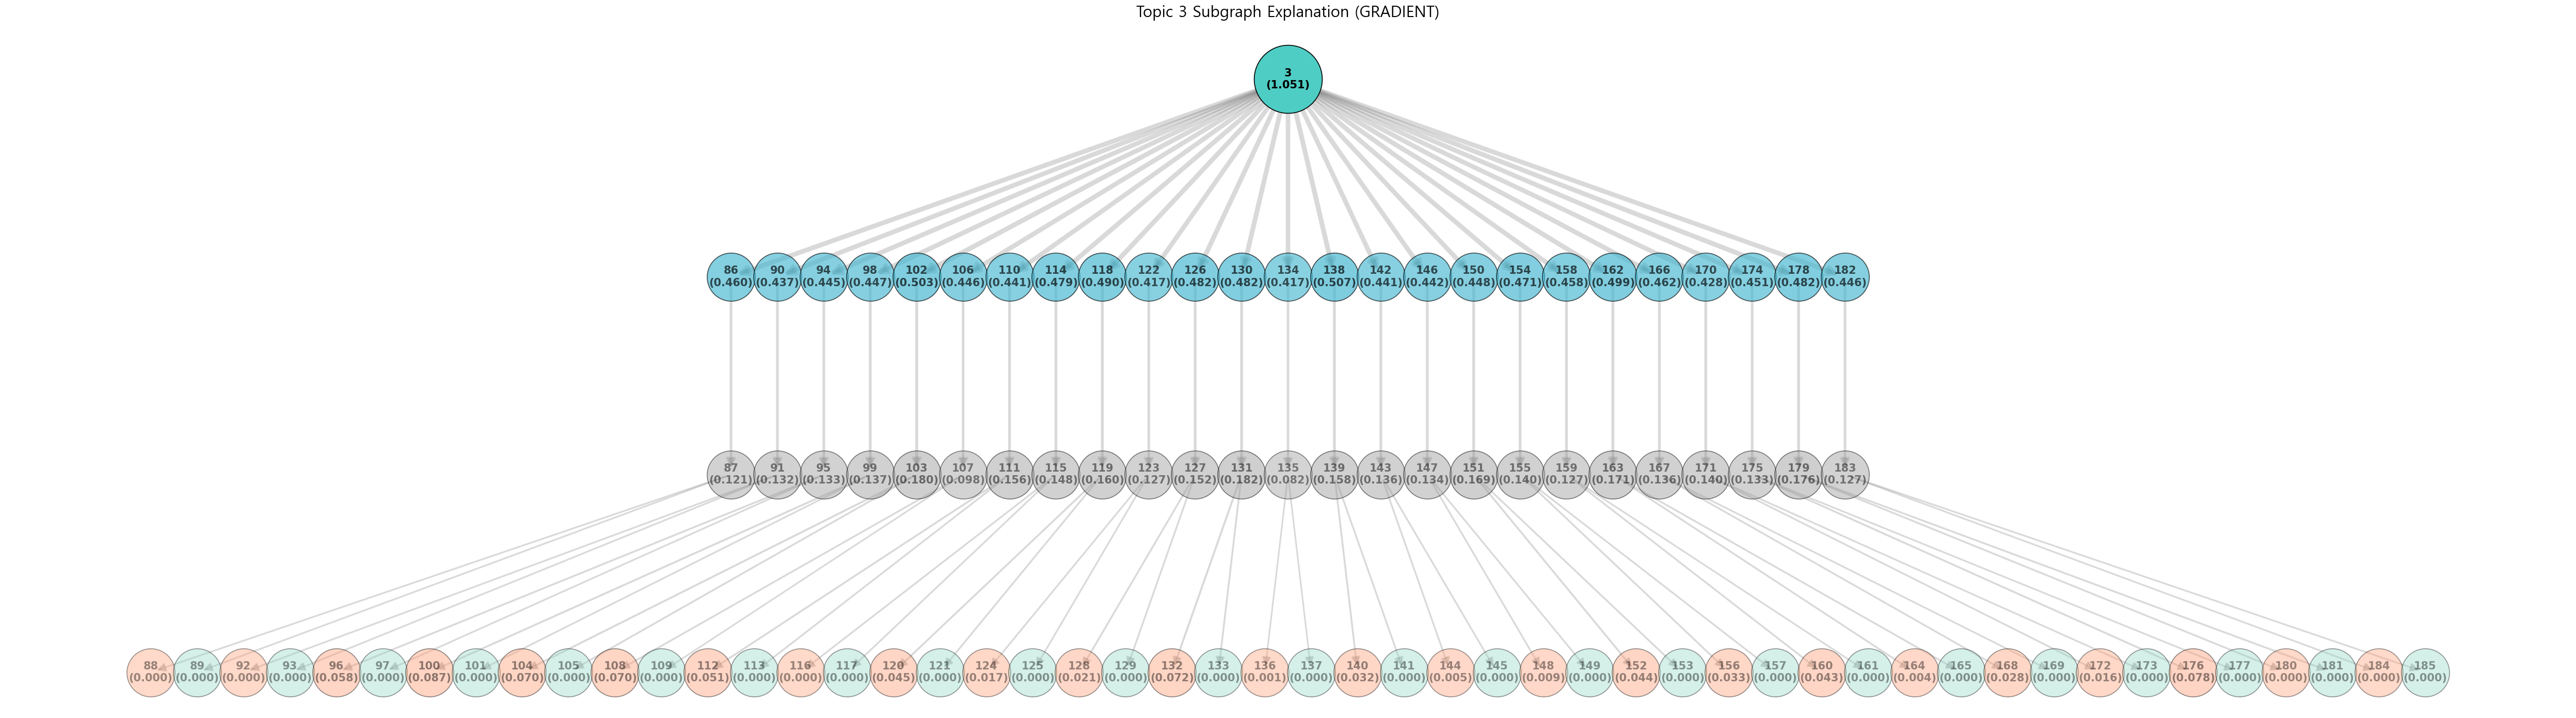

------------------------------------------------------------

▶ Method: GNN_EXPLAINER
  📷 Vision Importance | Avg: 0.7069, Max: 0.8819
  🎤 Audio Importance  | Avg: 0.7562, Max: 0.8168


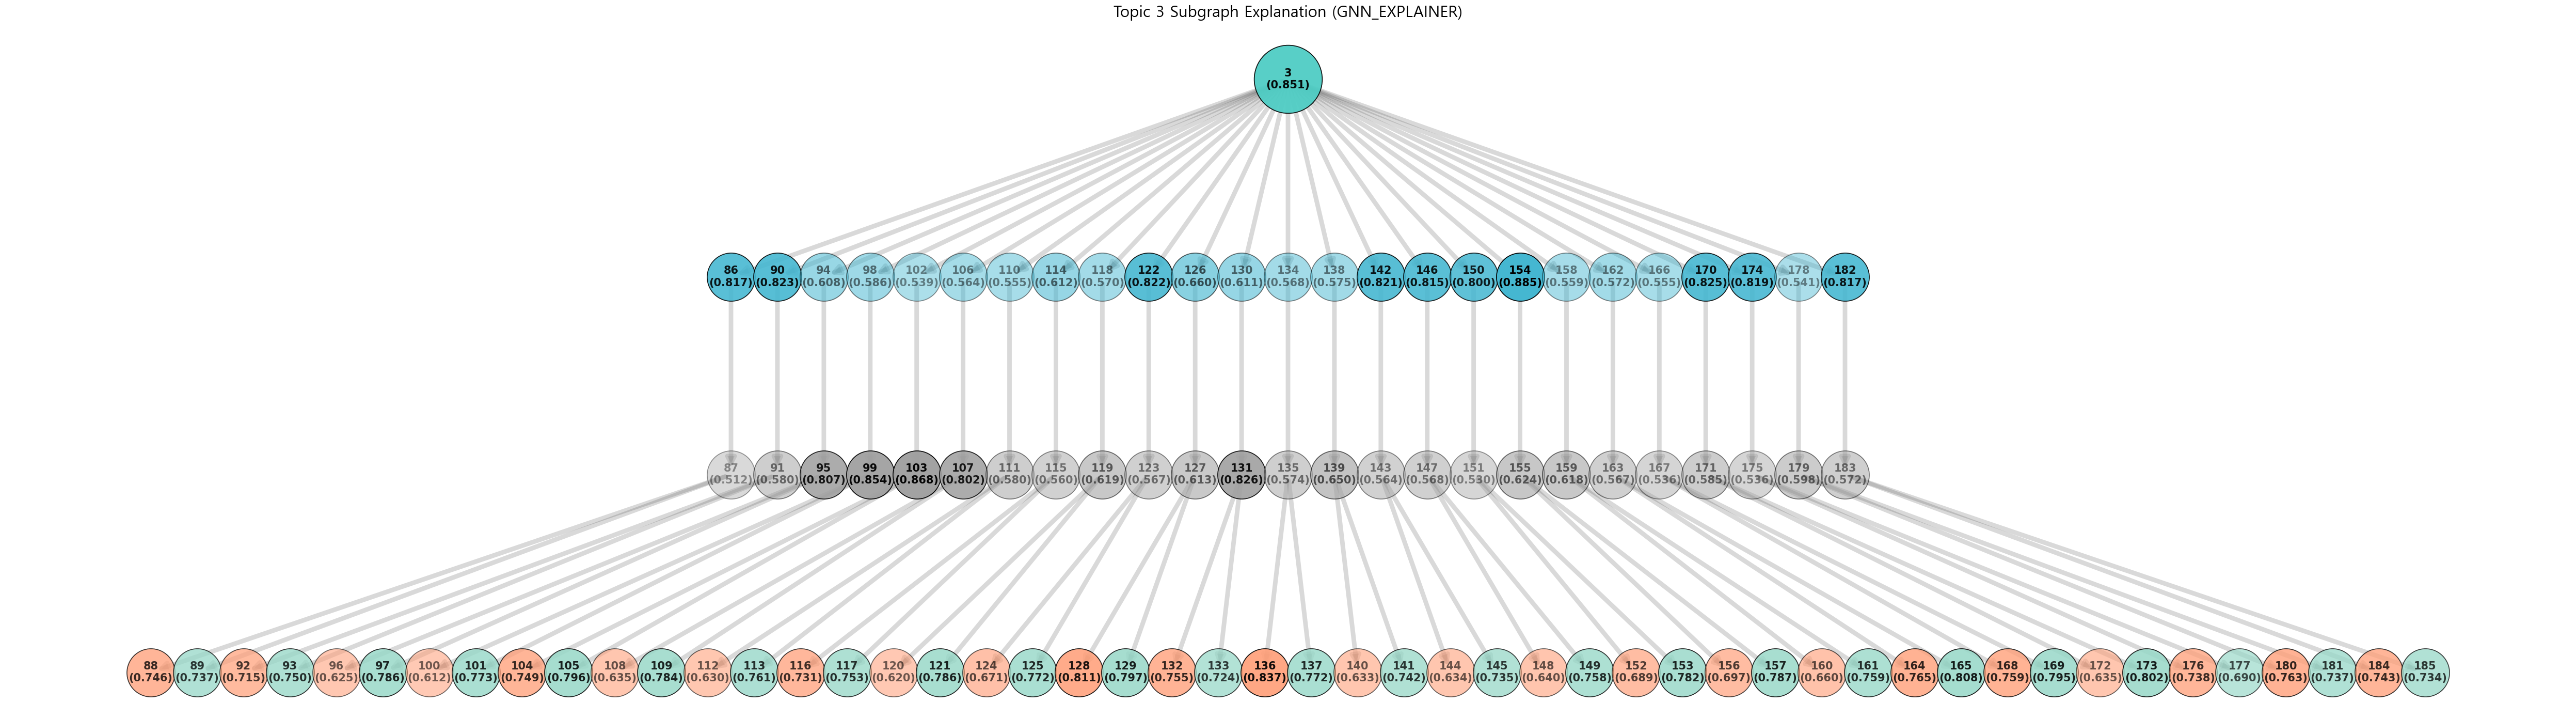

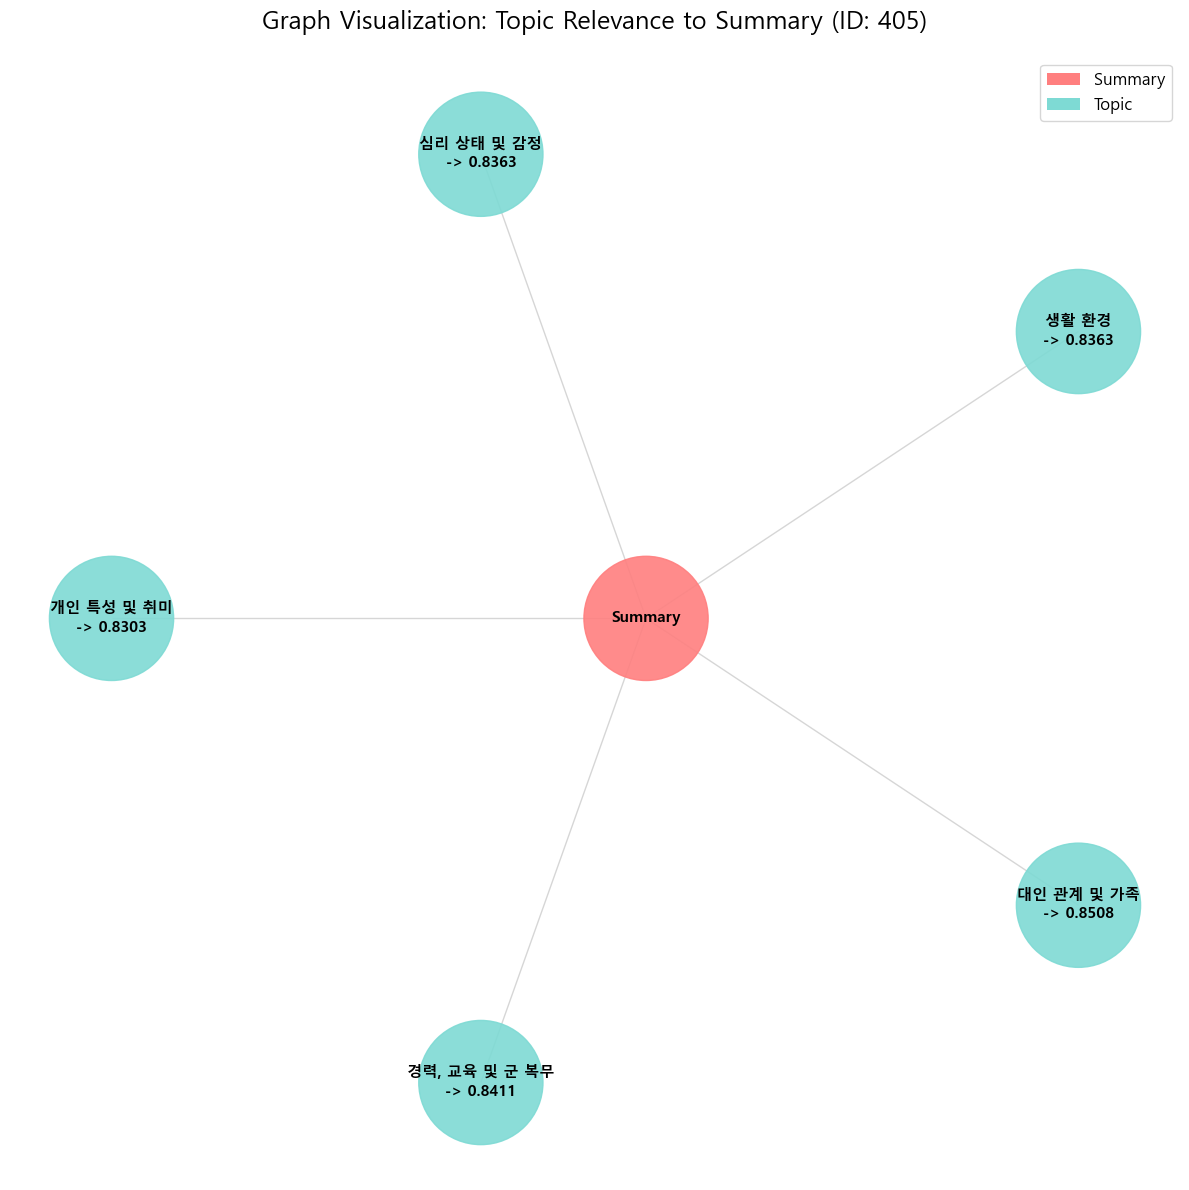

------------------------------------------------------------

✅ All visualizations completed.


In [27]:
target_graph = graphs[0].to(device)

all_topic_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'topic']
target_topic_idx = all_topic_indices[0] # 1번째 토픽을 타겟으로 설정

logger.info(f"Target Graph: {target_graph.num_nodes} nodes, {target_graph.num_edges} edges")
logger.info(f"Target Topic Node Index: {target_topic_idx}")
print("\n" + "="*60)
print("🎨 STARTING TOPIC-CENTERED VISUALIZATION FOR ALL METHODS")
print("="*60)

target_topic_idx = all_topic_indices[2]

for method_name, (node_attr, edge_attr, desc) in results.items():
  print(f"\n▶ Method: {desc}")

  vision_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'vision']
  audio_indices = [i for i, t in enumerate(target_graph.node_types) if t == 'audio']

  if vision_indices:
    v_imp = node_attr[vision_indices]
    print(f"  📷 Vision Importance | Avg: {v_imp.mean():.4f}, Max: {v_imp.max():.4f}")
  else:
    print("  📷 Vision Importance | No Vision Nodes")

  if audio_indices:
    a_imp = node_attr[audio_indices]
    print(f"  🎤 Audio Importance  | Avg: {a_imp.mean():.4f}, Max: {a_imp.max():.4f}")
  else:
    print("  🎤 Audio Importance  | No Audio Nodes")

  """
  if node_attr.max() != node_attr.min():
    norm_node_attr = (node_attr - node_attr.min()) / (node_attr.max() - node_attr.min() + 1e-9)
  else:
    norm_node_attr = node_attr

  if edge_attr is not None and edge_attr.max() != edge_attr.min():
    norm_edge_attr = (edge_attr - edge_attr.min()) / (edge_attr.max() - edge_attr.min() + 1e-9)
  else:
    norm_edge_attr = edge_attr
  """
  # 계층형 서브그래프 시각화 호출
  visualize_topic_subgraph(
    data=target_graph,
    # node_attr=norm_node_attr,
    node_attr=node_attr,
    # edge_attr=norm_edge_attr,
    edge_attr=edge_attr,
    target_topic_idx=target_topic_idx,
    title=f"Topic {target_topic_idx} Subgraph Explanation ({desc})"
  )

  if method_name == 'gnn':
    visualize_summary_topic_explanation(
      data=graphs[0],
      node_attr=node_attr,
      edge_attr=edge_attr,
      all_topic_indices=topic_node_dict.keys(),
      topic_labels=topic_node_dict
    )

  print("-" * 60)

print("\n✅ All visualizations completed.")

In [28]:
for id_, utter_ in zip(text_valid_ids, topic_utterances):
  print(f"{id_}: {utter_}")

86: hm. probably with my. husband. and. i can't remember at the moment what it was about.
90: um well when you say my family do you mean. my  family from childhood or my current family.
94: okay well i guess my current family comes to mind i i have two daughters. and. my relationship's pretty good it's okay with them but they're teenagers which uh. you know.  going they're going through a lot of hormones and
98: um. they can be kinda bitchy <laughter> and. and um but i have hoped that you know they'll grow out of that and soon someday we'll have a really good relationship.  um and then there's the husband which
102: i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah.  yeah so that that's not good the
106: the relationship with the husband but um. but since we have determined that we need to divorce.  our our we don't expect anything out out of each other so we don't argue as much 

## GNN_Explainer 결과

- 3번 주제(대인관계 및 가족)가 가장 중요한 주제로 선정

- 154번의 text node가 0.885로 전사 텍스트 중 가장 중요한 요소
> they surprised us and. had been talking to this other local agent. and uh yeah. that was devastating. i don't think i had ever  been betrayed.  like that
    - 'devastating'과 같은 감정 표현이 직접 들어나는 말 사용 + 'i don't think i had ever been betrayed like that'로 강조 어법 => 우울증(1번 클래스) 판별에 강한 영향력 행사<br></br>
- 102번의 text node는 0.539로 전사 텍스트 중 가장 중요하지 않은 요소
> i i guess i could say soon to be ex husband hopefully soon  <laughter>. we need to get a divorce but we're still together. due to financial reasons. and yeah.  yeah so that that's not good the
    - 가족 관계에서 문제를 겪고 있다는 사실적인 대화로, 텍스트 자체에는 큰 감정 표현이 드러나지 않음 => 이로써 텍스트 자체에 대한 중요도는 떨어질 수 있음
    - 그러나 연관된 프록시 노드(103번)의 중요도가 0.868로 가장 높음 => 텍스트 자체로 드러나지 않는 부분을 프록시 노드가 멀티모달적 요소를 적절히 융합함으로써 보완했음을 의미 -> 더욱 자세한 분석 필요<br></br>
- 166/167번의 text/proxy node는 중요도 평균 0.546으로 가장 낮은 종합 중요도
> run into each other at a summer camp or something they were just so connected they were. just you know like two peas in a pod even though it's her. their moms weren't talking to each other anymore.  so now they're thirteen and fourteen and they're in middle school together
    - 자식의 친구와 관련된 사실적인 이야기의 나열 => 감정적인 표현이 드러나지 않음 + pause는 우울증 판별에 핵심적인 특성으로 작용 but 다른 발화와 비교하였을 때, pause가 거의 없음 -> 모델이 중요하지 않은 발화를 적절히 필터링 했음을 의미<br></br>
- 모델이 우울증 판별에 있어서 중요한 부분을 찾아내고, 이를 활용하여 임베딩을 업데이트하며 학습했다는 사실을 확인할 수 있음
- 특히, text 노드와 proxy 노드 사이의 적절한 균형 유지를 통해 멀티모달적 요소의 중요도를 판단하고 적절한 요소를 선택하는 경향을 볼 수 있음<br></br>
- 그러나 아직 성능이 완벽하게 높지 않다는 점에서 대부분의 임베딩 중요도가 비슷하게 나오고, 몇 노드들은 상식적인 판단에서 약간 벗어나는 모습 -> 더욱 간단한 모델을 통해 해석의 직관성을 높이고, 동시에 성능을 끌어올릴 수 있는 방안이 필요할 것이라고 생각

## Examining 105 audio node

In [71]:
audio_df_path = os.path.join(path_config.RAW_DATA_DIR, '405_P', '405_COVAREP.csv')
covarep_df = pd.read_csv(audio_df_path, header=None)
covarep_df = covarep_df.rename(
  columns={
    0:'F0', 1: 'VUV',
    2:'NAQ', 3:'QOQ',
    4:'H1H2', 5:'PSP',
    6:'MDQ', 7:'peakSlope',
    8:'Rd'
  }
)

In [72]:
start, stop = start_stop_list[text_indices.index(102)]
node = covarep_df.iloc[int(start*100):int(stop*100)]
analysis_list = ['F0', 'VUV', 'NAQ', 'QOQ', 'H1H2', 'PSP', 'MDQ', 'peakSlope', 'Rd']
unsounded_node = node.loc[node.VUV == 0, analysis_list]
valid_node = node.loc[node.VUV == 1, analysis_list]

In [73]:
relationship = covarep_df.iloc[35187:82144]
total_unsounded_node = relationship.loc[relationship.VUV == 0, analysis_list]
total_valid_node = relationship.loc[relationship.VUV == 1, analysis_list]

total_unsounded_node_without = total_unsounded_node.drop(unsounded_node.index, axis=0)
total_valid_node_without = total_valid_node.drop(valid_node.index, axis = 0)

In [74]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x):
  stat, p_value, lags, nobs, crit, icb = adfuller(x)
  return stat, p_value

In [75]:
plot_list = ['NAQ', 'QOQ', 'H1H2', 'PSP', 'MDQ', 'peakSlope', 'Rd']

In [76]:
for feature in plot_list:
  x = valid_node[feature].dropna()
  y = total_valid_node_without[feature].dropna()
  x_stat, x_p_val = adf_test(x)
  y_stat, y_p_val = adf_test(y)
  logger.info(f"{feature} 정상성 검정")
  logger.info(f"  32번 노드 -> 통계량: {x_stat}, p값: {x_p_val}")
  logger.info(f"  전체 노드 -> 통계량: {y_stat}, p값: {y_p_val}")

01:26:02 | INFO     | NAQ 정상성 검정
01:26:02 | INFO     |   32번 노드 -> 통계량: -10.484445905844353, p값: 1.1903957268135923e-18
01:26:02 | INFO     |   전체 노드 -> 통계량: -22.705303207776897, p값: 0.0
01:26:03 | INFO     | QOQ 정상성 검정
01:26:03 | INFO     |   32번 노드 -> 통계량: -8.21733192596686, p값: 6.570221562614191e-13
01:26:03 | INFO     |   전체 노드 -> 통계량: -13.780759617159536, p값: 9.306007655300687e-26
01:26:04 | INFO     | H1H2 정상성 검정
01:26:04 | INFO     |   32번 노드 -> 통계량: -10.236743260043971, p값: 4.8668253585309e-18
01:26:04 | INFO     |   전체 노드 -> 통계량: -14.078907153697918, p값: 2.851890509921854e-26
01:26:05 | INFO     | PSP 정상성 검정
01:26:05 | INFO     |   32번 노드 -> 통계량: -7.507988326496834, p값: 4.08617514019253e-11
01:26:05 | INFO     |   전체 노드 -> 통계량: -19.21694977233227, p값: 0.0
01:26:06 | INFO     | MDQ 정상성 검정
01:26:06 | INFO     |   32번 노드 -> 통계량: -9.001525632090859, p값: 6.47799140240131e-15
01:26:06 | INFO     |   전체 노드 -> 통계량: -7.245319608114319, p값: 1.838737458535081e-10
01:26:07 | INFO     | pe

In [77]:
from statsmodels.stats.stattools import durbin_watson

for feature in plot_list:
  x = valid_node[feature].dropna()
  y = total_valid_node_without[feature].dropna()
  x_dw_stat = durbin_watson(x)
  y_dw_stat = durbin_watson(y)
  
  # 해석 결과 출력
  x_status = "자기상관 없음"
  if x_dw_stat < 1.5: x_status = "양의 자기상관 가능성"
  if x_dw_stat > 2.5: x_status = "음의 자기상관 가능성"
  
  y_status = "자기상관 없음"
  if y_dw_stat < 1.5: y_status = "양의 자기상관 가능성"
  if y_dw_stat > 2.5: y_status = "음의 자기상관 가능성"
  
  logger.info(f"{feature} 자기상관성 검정")
  logger.info(f"  84번 노드 -> 통계량: {x_dw_stat:.4f}, {x_status}")
  logger.info(f"  전체 노드 -> 통계량: {y_dw_stat:.4f}, {y_status}")

01:26:08 | INFO     | NAQ 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.2244, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.1738, 양의 자기상관 가능성
01:26:08 | INFO     | QOQ 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.1547, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.1202, 양의 자기상관 가능성
01:26:08 | INFO     | H1H2 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.6401, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.4194, 양의 자기상관 가능성
01:26:08 | INFO     | PSP 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.5223, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.3751, 양의 자기상관 가능성
01:26:08 | INFO     | MDQ 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.0458, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.0474, 양의 자기상관 가능성
01:26:08 | INFO     | peakSlope 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.0073, 양의 자기상관 가능성
01:26:08 | INFO     |   전체 노드 -> 통계량: 0.0048, 양의 자기상관 가능성
01:26:08 | INFO     | Rd 자기상관성 검정
01:26:08 | INFO     |   84번 노드 -> 통계량: 0.0683, 

In [78]:
# Newey-West t-검정

import statsmodels.formula.api as smf

newey_west_result = {}

for feature in plot_list:
  df = valid_node[[feature]].copy(); df['group'] = 1
  df_total = total_valid_node_without[[feature]].copy(); df_total['group'] = 0
  combined = pd.concat([df, df_total])
  model = smf.ols(f'{feature} ~ group', data=combined).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  p_val = model.pvalues['group']
  coef = model.params['group']
  newey_west_result[feature] = {
    'p_value':p_val,
    'coefficient':coef
  }

In [79]:
pd.DataFrame.from_dict(newey_west_result, orient='index')

p_value  coefficient
NAQ         1.149807e-13    -0.015755
QOQ         3.179786e-15    -0.042673
H1H2        8.423188e-02    -0.493353
PSP         9.623980e-01     0.000264
MDQ        1.516342e-136     0.024357
peakSlope   6.033487e-01     0.001758
Rd          1.417843e-03    -0.076018

In [81]:
ts_others = total_valid_node_without[target]
ts_baseline = ts_others.groupby(ts_others.index).mean()

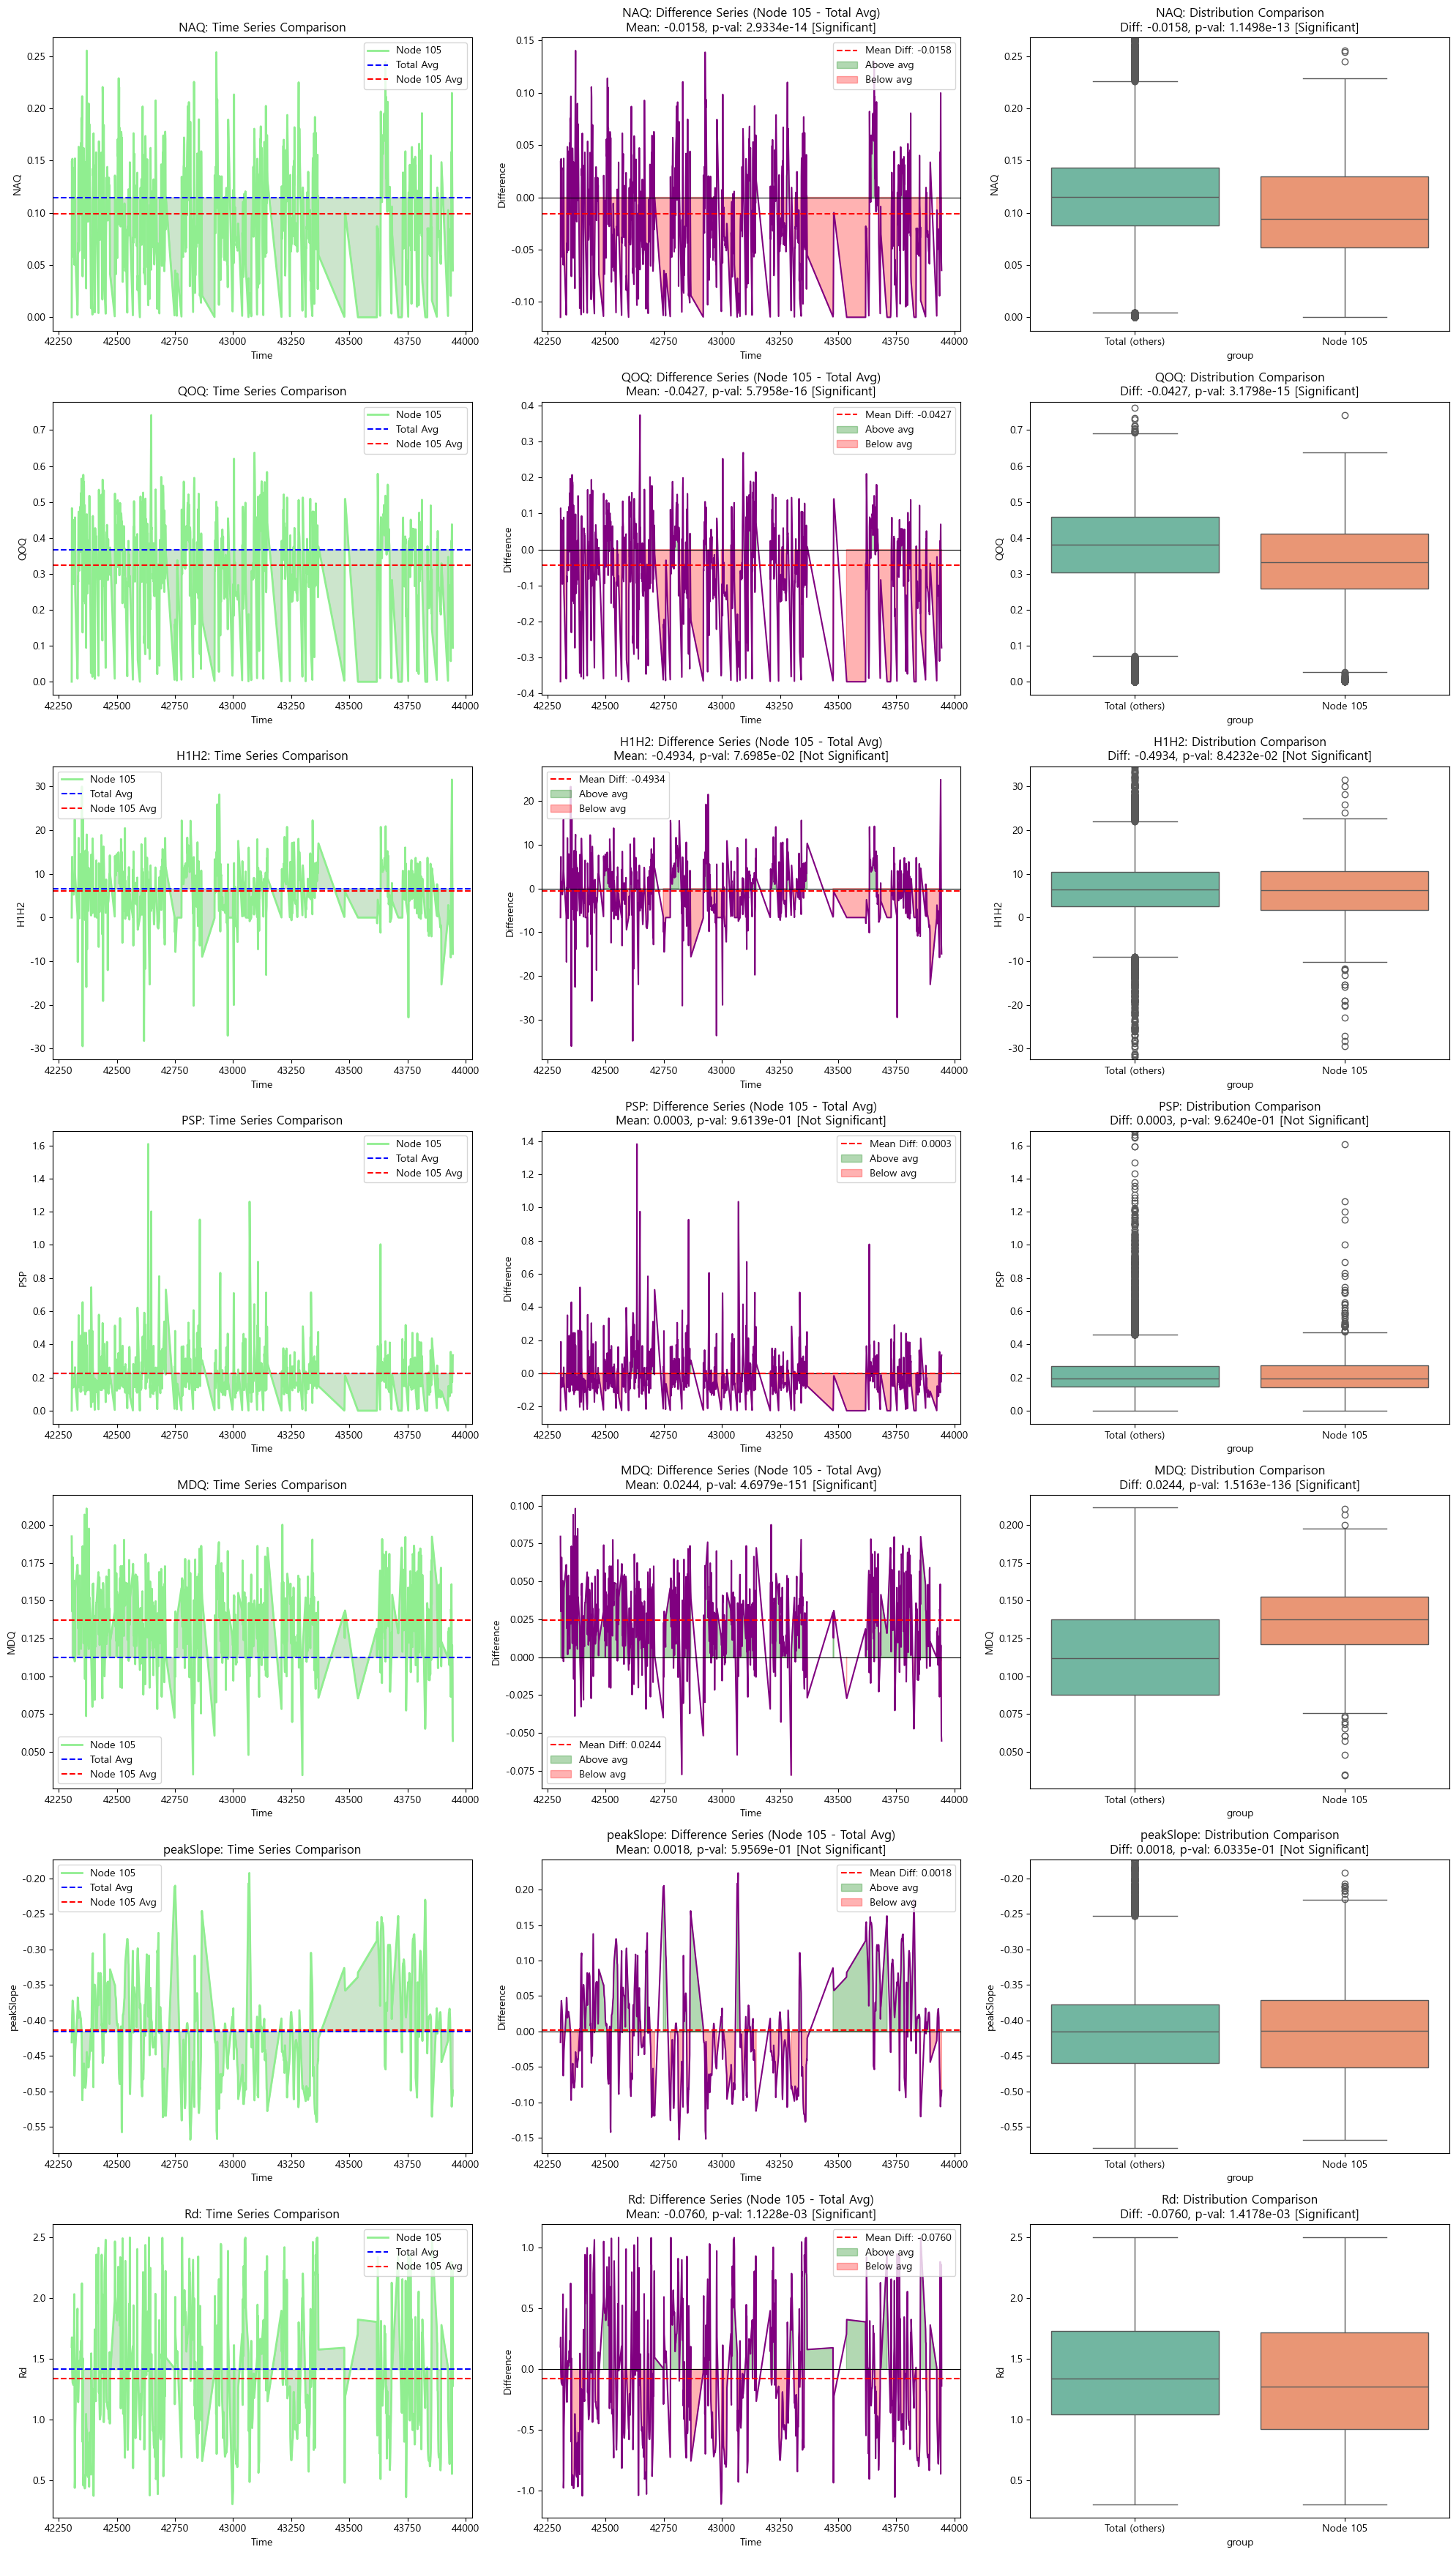

In [86]:
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(len(plot_list), 3, figsize=(20, 5 * len(plot_list)))

for i, target in enumerate(plot_list):
  df = valid_node[[target]].copy()
  df['group'] = 1
  df_total = total_valid_node_without[[target]].copy()
  df_total['group'] = 0
  combined = pd.concat([df, df_total])
    
  model = smf.ols(f'{target} ~ group', data=combined).fit(
    cov_type='HAC', cov_kwds={'maxlags': 1}
  )
  nw_p_val = model.pvalues['group']
  nw_coef = model.params['group']
    
  diff_series = df[target].values - df_total[target].mean()
    
  diff_df = pd.DataFrame({'diff': diff_series, 'const': 1})
  diff_model = smf.ols('diff ~ 1', data=diff_df).fit(
    cov_type='HAC', cov_kwds={'maxlags': 1}
  )
  diff_p_val = diff_model.pvalues['Intercept']
  diff_mean = diff_model.params['Intercept']

  sns.lineplot(data=valid_node, x=valid_node.index, y=target, 
               ax=ax[i,0], color='lightgreen', label='Node 105', linewidth=2)
  ax[i,0].axhline(y=total_valid_node_without[target].mean(), 
                  color='blue', linestyle='--', linewidth=1.5, label='Total Avg')
  ax[i,0].axhline(y=valid_node[target].mean(), 
                  color='red', linestyle='--', linewidth=1.5, label='Node 105 Avg')
  ax[i,0].fill_between(valid_node.index, 
                       total_valid_node_without[target].mean(), 
                       valid_node[target],
                       alpha=0.2, color='green')
  ax[i,0].set_title(f"{target}: Time Series Comparison")
  ax[i,0].legend()
  ax[i,0].set_xlabel('Time')
    
  ax[i,1].plot(valid_node.index, diff_series, color='purple', linewidth=1.5)
  ax[i,1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
  ax[i,1].axhline(y=diff_mean, color='red', linestyle='--', linewidth=1.5, 
                  label=f'Mean Diff: {diff_mean:.4f}')
  ax[i,1].fill_between(valid_node.index, 0, diff_series, 
                       where=(diff_series > 0), alpha=0.3, color='green', 
                       label='Above avg')
  ax[i,1].fill_between(valid_node.index, 0, diff_series, 
                       where=(diff_series <= 0), alpha=0.3, color='red',
                       label='Below avg')
  significance = "Significant" if diff_p_val < 0.05 else "Not Significant"
  ax[i,1].set_title(f"{target}: Difference Series (Node 105 - Total Avg)\n"
                   f"Mean: {diff_mean:.4f}, p-val: {diff_p_val:.4e} [{significance}]")
  ax[i,1].legend()
  ax[i,1].set_xlabel('Time')
  ax[i,1].set_ylabel('Difference')
  
  sns.boxplot(data=combined, x='group', y=target, ax=ax[i,2], 
              hue='group', palette='Set2', legend=False)
  ax[i,2].set_xticks([0,1])
  ax[i,2].set_xticklabels(['Total (others)', 'Node 105'])
  
  ymin, ymax = ax[i,0].get_ylim()
  ax[i,2].set_ylim(ymin, ymax)
  
  significance_group = "Significant" if nw_p_val < 0.05 else "Not Significant"
  ax[i,2].set_title(f"{target}: Distribution Comparison\n"
                    f"Diff: {nw_coef:.4f}, p-val: {nw_p_val:.4e} [{significance_group}]")
  
plt.tight_layout()
plt.show()

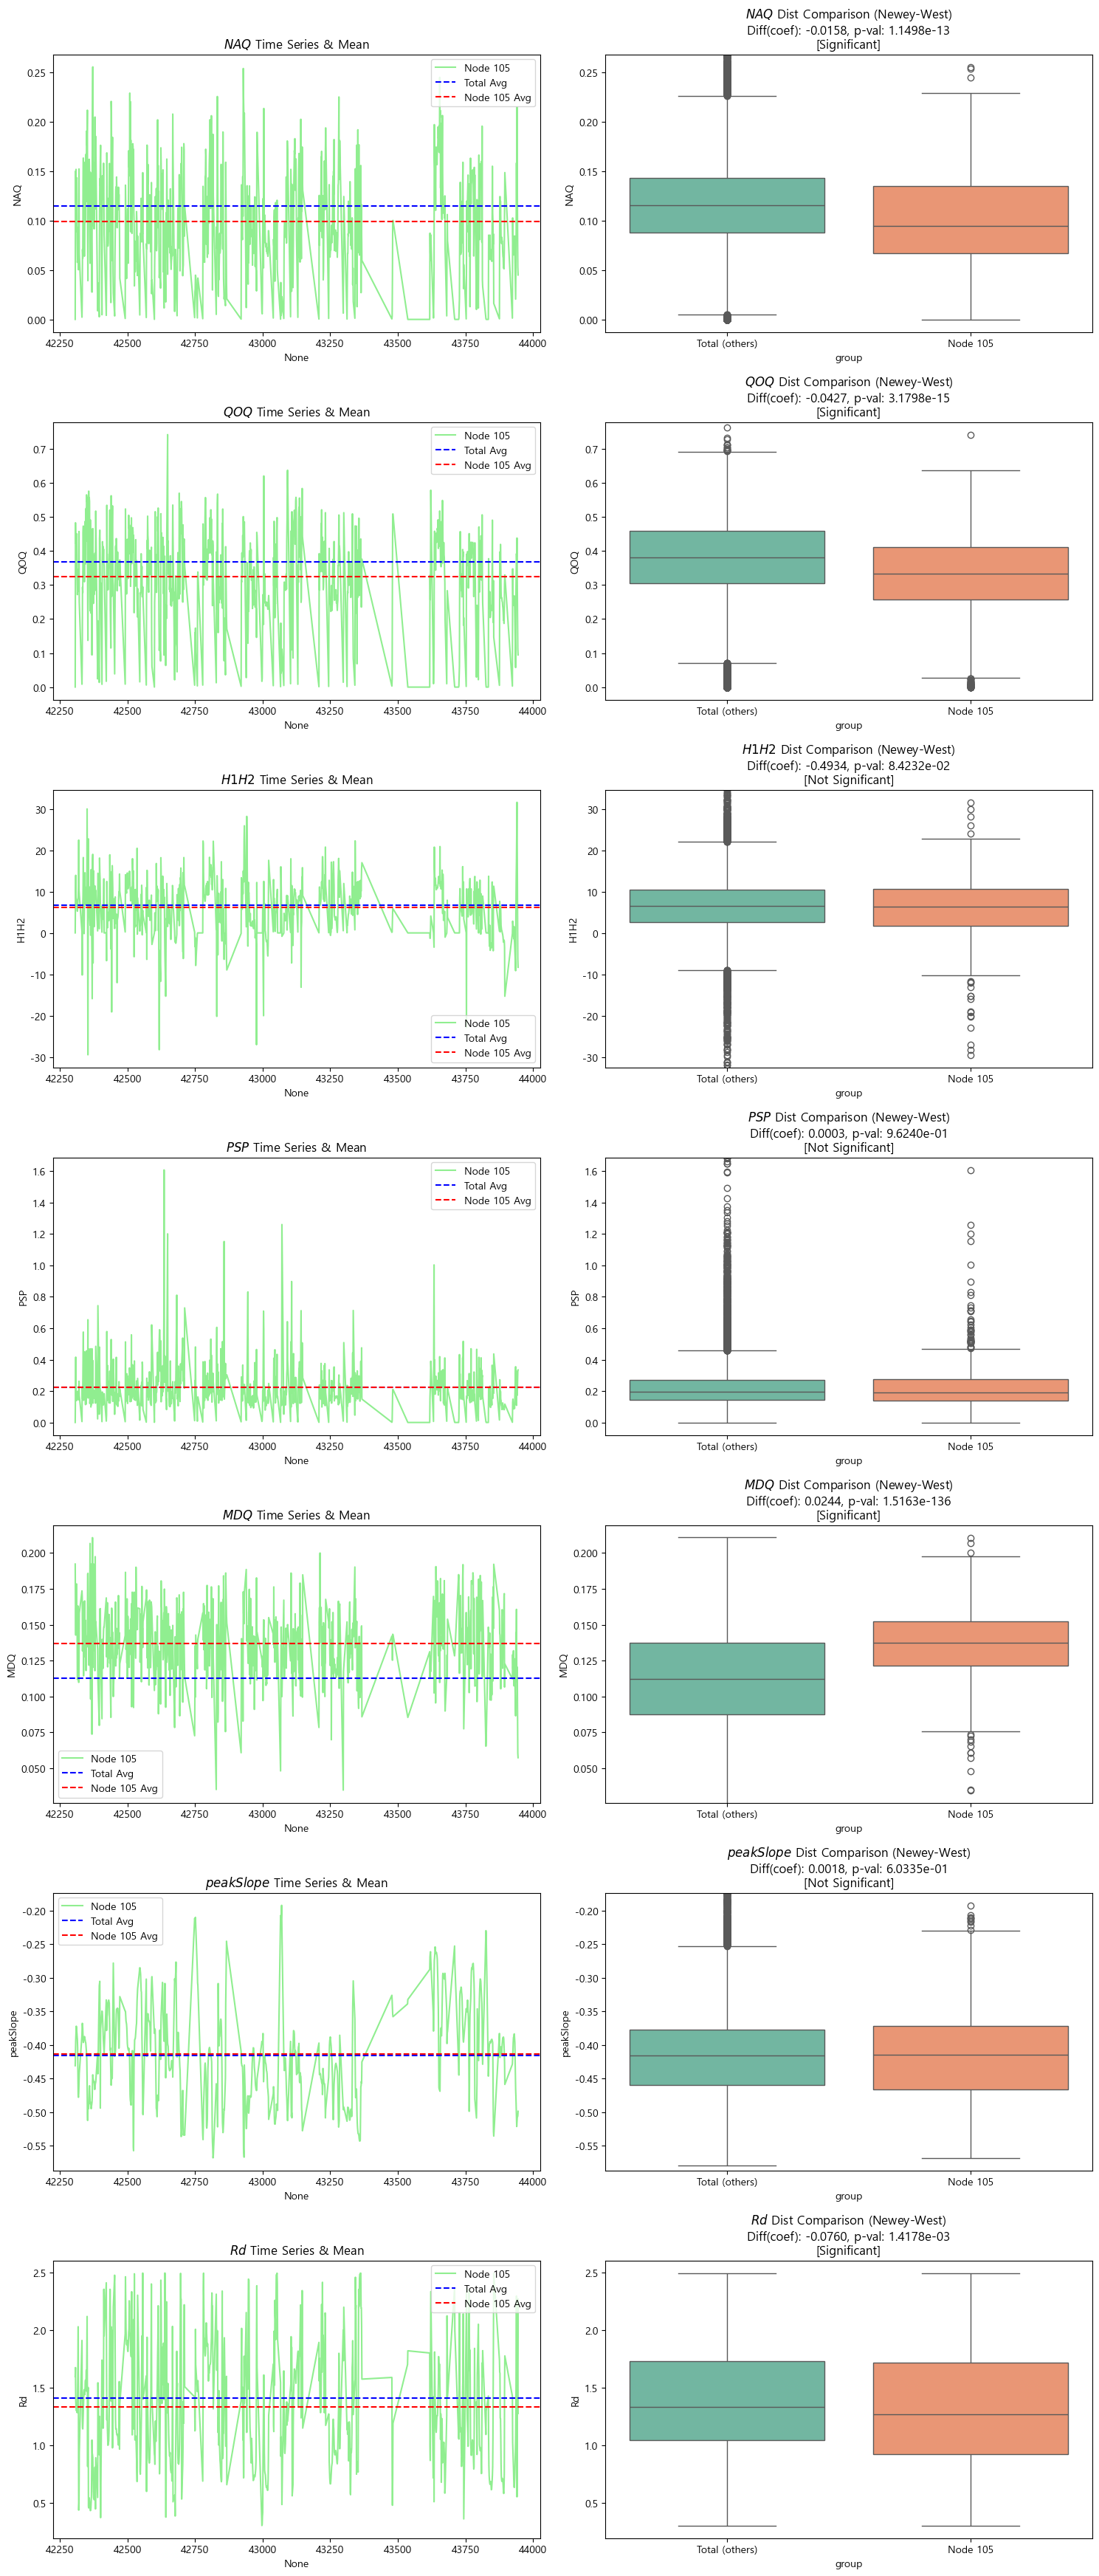

In [51]:
import statsmodels.formula.api as smf
import seaborn as sns

fig, ax = plt.subplots(len(plot_list), 2, figsize=(15, 5 * len(plot_list)))

for i, target in enumerate(plot_list):
  df = valid_node[[target]].copy(); df['group'] = 1
  df_total = total_valid_node_without[[target]].copy(); df_total['group'] = 0
  combined = pd.concat([df, df_total])
  
  model = smf.ols(f'{target} ~ group', data=combined).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
  
  nw_p_val = model.pvalues['group']  # Newey-West로 보정된 p-value
  nw_coef = model.params['group']    # 두 집단의 평균 차이 (beta1)
  
  sns.lineplot(data=valid_node, x=valid_node.index, y=target, ax=ax[i,0], color='lightgreen', label='Node 105')
  ax[i,0].axhline(y=total_valid_node_without[target].mean(), color='blue', linestyle='--', label='Total Avg')
  ax[i,0].axhline(y=valid_node[target].mean(), color='red', linestyle='--', label='Node 105 Avg')
  ax[i,0].set_title(f"${target}$ Time Series & Mean")
  ax[i,0].legend()

  sns.boxplot(data=combined, x='group', y=target, ax=ax[i,1], hue='group', palette='Set2', legend=False)
  ax[i,1].set_xticks([0,1])
  ax[i,1].set_xticklabels(['Total (others)', 'Node 105'])
  
  ymin, ymax = ax[i,0].get_ylim()
  ax[i,1].set_ylim(ymin, ymax)
  
  significance = "Significant" if nw_p_val < 0.05 else "Not Significant"
  ax[i,1].set_title(f"${target}$ Dist Comparison (Newey-West)\nDiff(coef): {nw_coef:.4f}, p-val: {nw_p_val:.4e}\n[{significance}]")

plt.tight_layout()
plt.show()

## Examining 104 vision node

In [87]:
try:
  vision_df_path = os.path.join(path_config.DATA_DIR, 'Vision Summary', '405_vision_summary.csv')
  vision_df = pd.read_csv(vision_df_path, header=0)

  valid_vision_df = vision_df.loc[(423.04 <= vision_df['timestamp']) & (vision_df['timestamp'] <= 439.48)]
  relationship = vision_df.loc[(351.87 <= vision_df['timestamp']) & (vision_df['timestamp'] <= 821.44)]

  gz_df = valid_vision_df.filter(like='gz')
  gz_df_total = relationship.filter(like='gz').drop(valid_vision_df.index, axis = 0)

  gaze_rename_dict = {
    col:col.split()[1]
    for col in gz_df.columns
  }

  gz_df = gz_df.rename(columns=gaze_rename_dict)
  gz_df_total = gz_df_total.rename(columns=gaze_rename_dict)

  gz_df['x'] = (gz_df['x_0'] + gz_df['x_1']) / 2; gz_df['y'] = (gz_df['y_0'] + gz_df['y_1']) / 2; gz_df['z'] = (gz_df['z_0'] + gz_df['z_1']) / 2
  gz_df['xh'] = (gz_df['x_h0'] + gz_df['x_h1']) / 2; gz_df['yh'] = (gz_df['y_h0'] + gz_df['y_h1']) / 2; gz_df['zh'] = (gz_df['z_h0'] + gz_df['z_h1']) / 2

  gz_df_total['x'] = (gz_df_total['x_0'] + gz_df_total['x_1']) / 2; gz_df_total['y'] = (gz_df_total['y_0'] + gz_df_total['y_1']) / 2; gz_df_total['z'] = (gz_df_total['z_0'] + gz_df_total['z_1']) / 2
  gz_df_total['xh'] = (gz_df_total['x_h0'] + gz_df_total['x_h1']) / 2; gz_df_total['yh'] = (gz_df_total['y_h0'] + gz_df_total['y_h1']) / 2; gz_df_total['zh'] = (gz_df_total['z_h0'] + gz_df_total['z_h1']) / 2
except Exception as e:
  print(e)

In [88]:
vision_plot_list = ['x', 'y', 'z', 'xh', 'yh', 'zh']

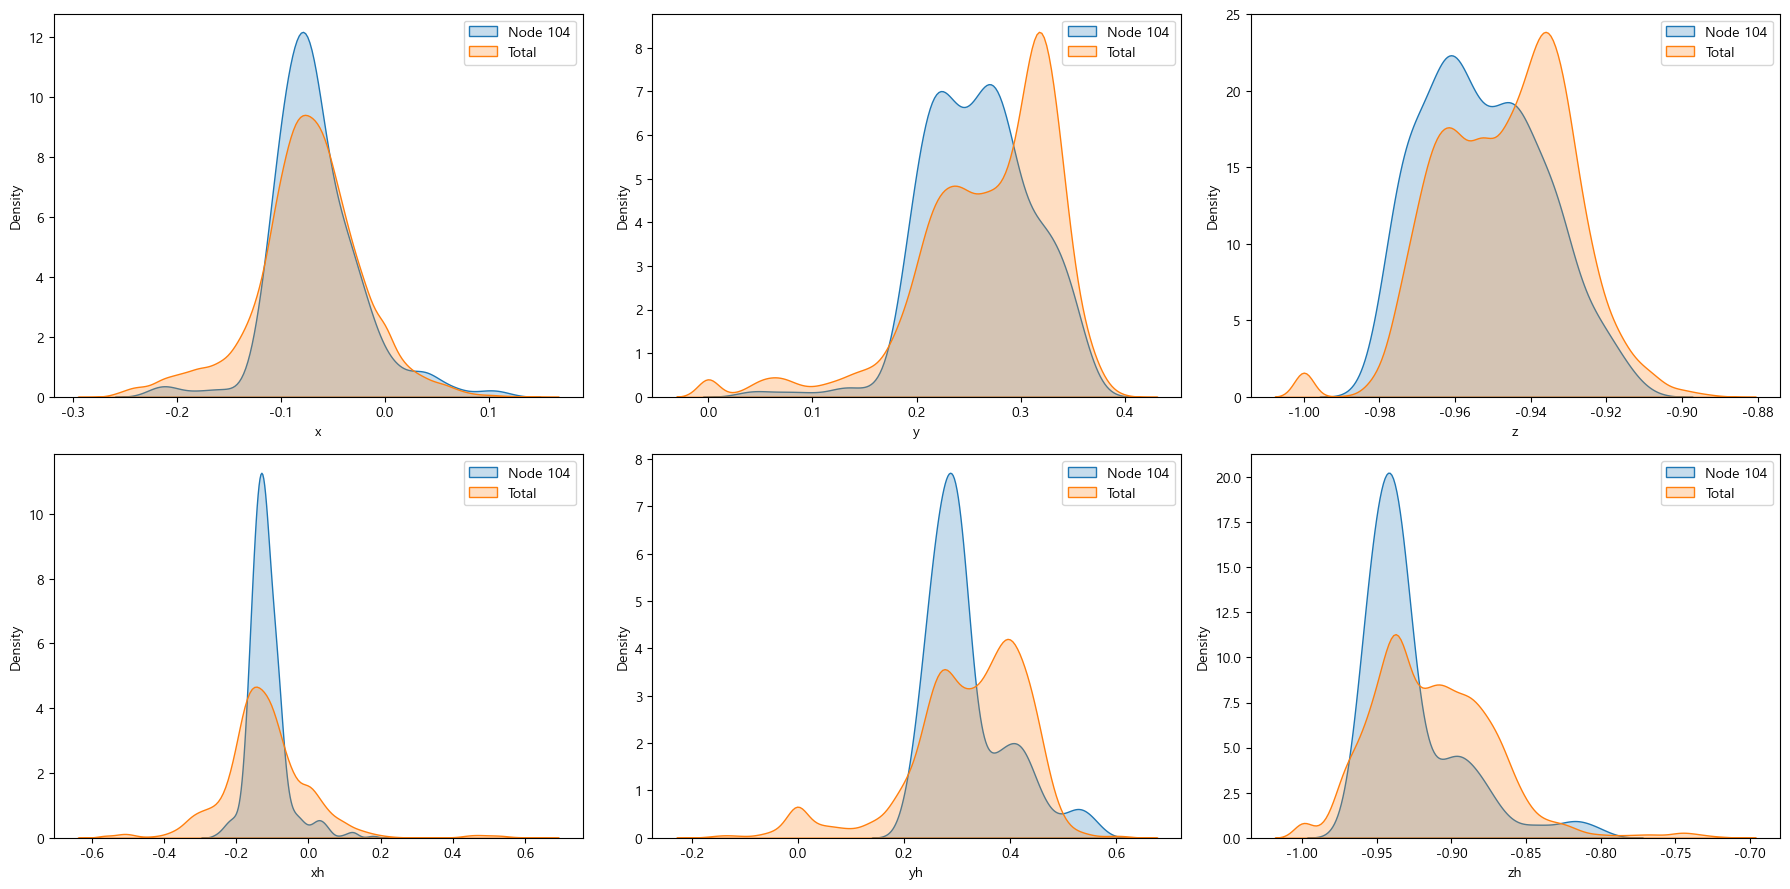

In [89]:
try:
  fig, ax = plt.subplots(2,3, figsize=(18,9))
  for i, feat in enumerate(vision_plot_list):
    col = i%3
    row = i//3
    sns.kdeplot(gz_df[feat], ax=ax[row, col], fill=True, label='Node 104')
    sns.kdeplot(gz_df_total[feat], ax=ax[row, col], fill=True, label='Total')
    ax[row, col].legend()
  plt.tight_layout()
  plt.show()
except Exception as e:
  print(e)

In [90]:
from statsmodels.stats.stattools import durbin_watson
try:
  for feature in vision_plot_list:
    x = gz_df[feature].dropna()
    y = gz_df_total[feature].dropna()
    x_dw_stat = durbin_watson(x)
    y_dw_stat = durbin_watson(y)

    # 해석 결과 출력
    x_status = "자기상관 없음"
    if x_dw_stat < 1.5: x_status = "양의 자기상관 가능성"
    if x_dw_stat > 2.5: x_status = "음의 자기상관 가능성"

    y_status = "자기상관 없음"
    if y_dw_stat < 1.5: y_status = "양의 자기상관 가능성"
    if y_dw_stat > 2.5: y_status = "음의 자기상관 가능성"

    logger.info(f"{feature} 자기상관성 검정")
    logger.info(f"  84번 노드 -> 통계량: {x_dw_stat:.4f}, {x_status}")
    logger.info(f"  전체 노드 -> 통계량: {y_dw_stat:.4f}, {y_status}")
except Exception as e:
  print(e)

01:39:31 | INFO     | x 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0878, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0746, 양의 자기상관 가능성
01:39:31 | INFO     | y 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0057, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0065, 양의 자기상관 가능성
01:39:31 | INFO     | z 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0000, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0001, 양의 자기상관 가능성
01:39:31 | INFO     | xh 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0382, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0275, 양의 자기상관 가능성
01:39:31 | INFO     | yh 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0047, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0057, 양의 자기상관 가능성
01:39:31 | INFO     | zh 자기상관성 검정
01:39:31 | INFO     |   84번 노드 -> 통계량: 0.0001, 양의 자기상관 가능성
01:39:31 | INFO     |   전체 노드 -> 통계량: 0.0001, 양의 자기상관 가능성


In [91]:
# Newey-West t-검정
import statsmodels.formula.api as smf

try:
  newey_west_result = {}

  for feature in vision_plot_list:
    df = gz_df[[feature]].copy(); df['group'] = 1
    df_total = gz_df_total[[feature]].copy(); df_total['group'] = 0
    combined = pd.concat([df, df_total])
    model = smf.ols(f'{feature} ~ group', data=combined).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    p_val = model.pvalues['group']
    coef = model.params['group']
    newey_west_result[feature] = {
      'p_value':p_val,
      'coefficient':coef
    }
  display(pd.DataFrame.from_dict(newey_west_result, orient='index'))
except Exception as e:
  print(e)

p_value  coefficient
x   9.315697e-03     0.007141
y   8.106372e-03    -0.008697
z   1.877402e-09    -0.006029
xh  8.506579e-01     0.000653
yh  7.218054e-01    -0.001765
zh  1.701947e-11    -0.014192

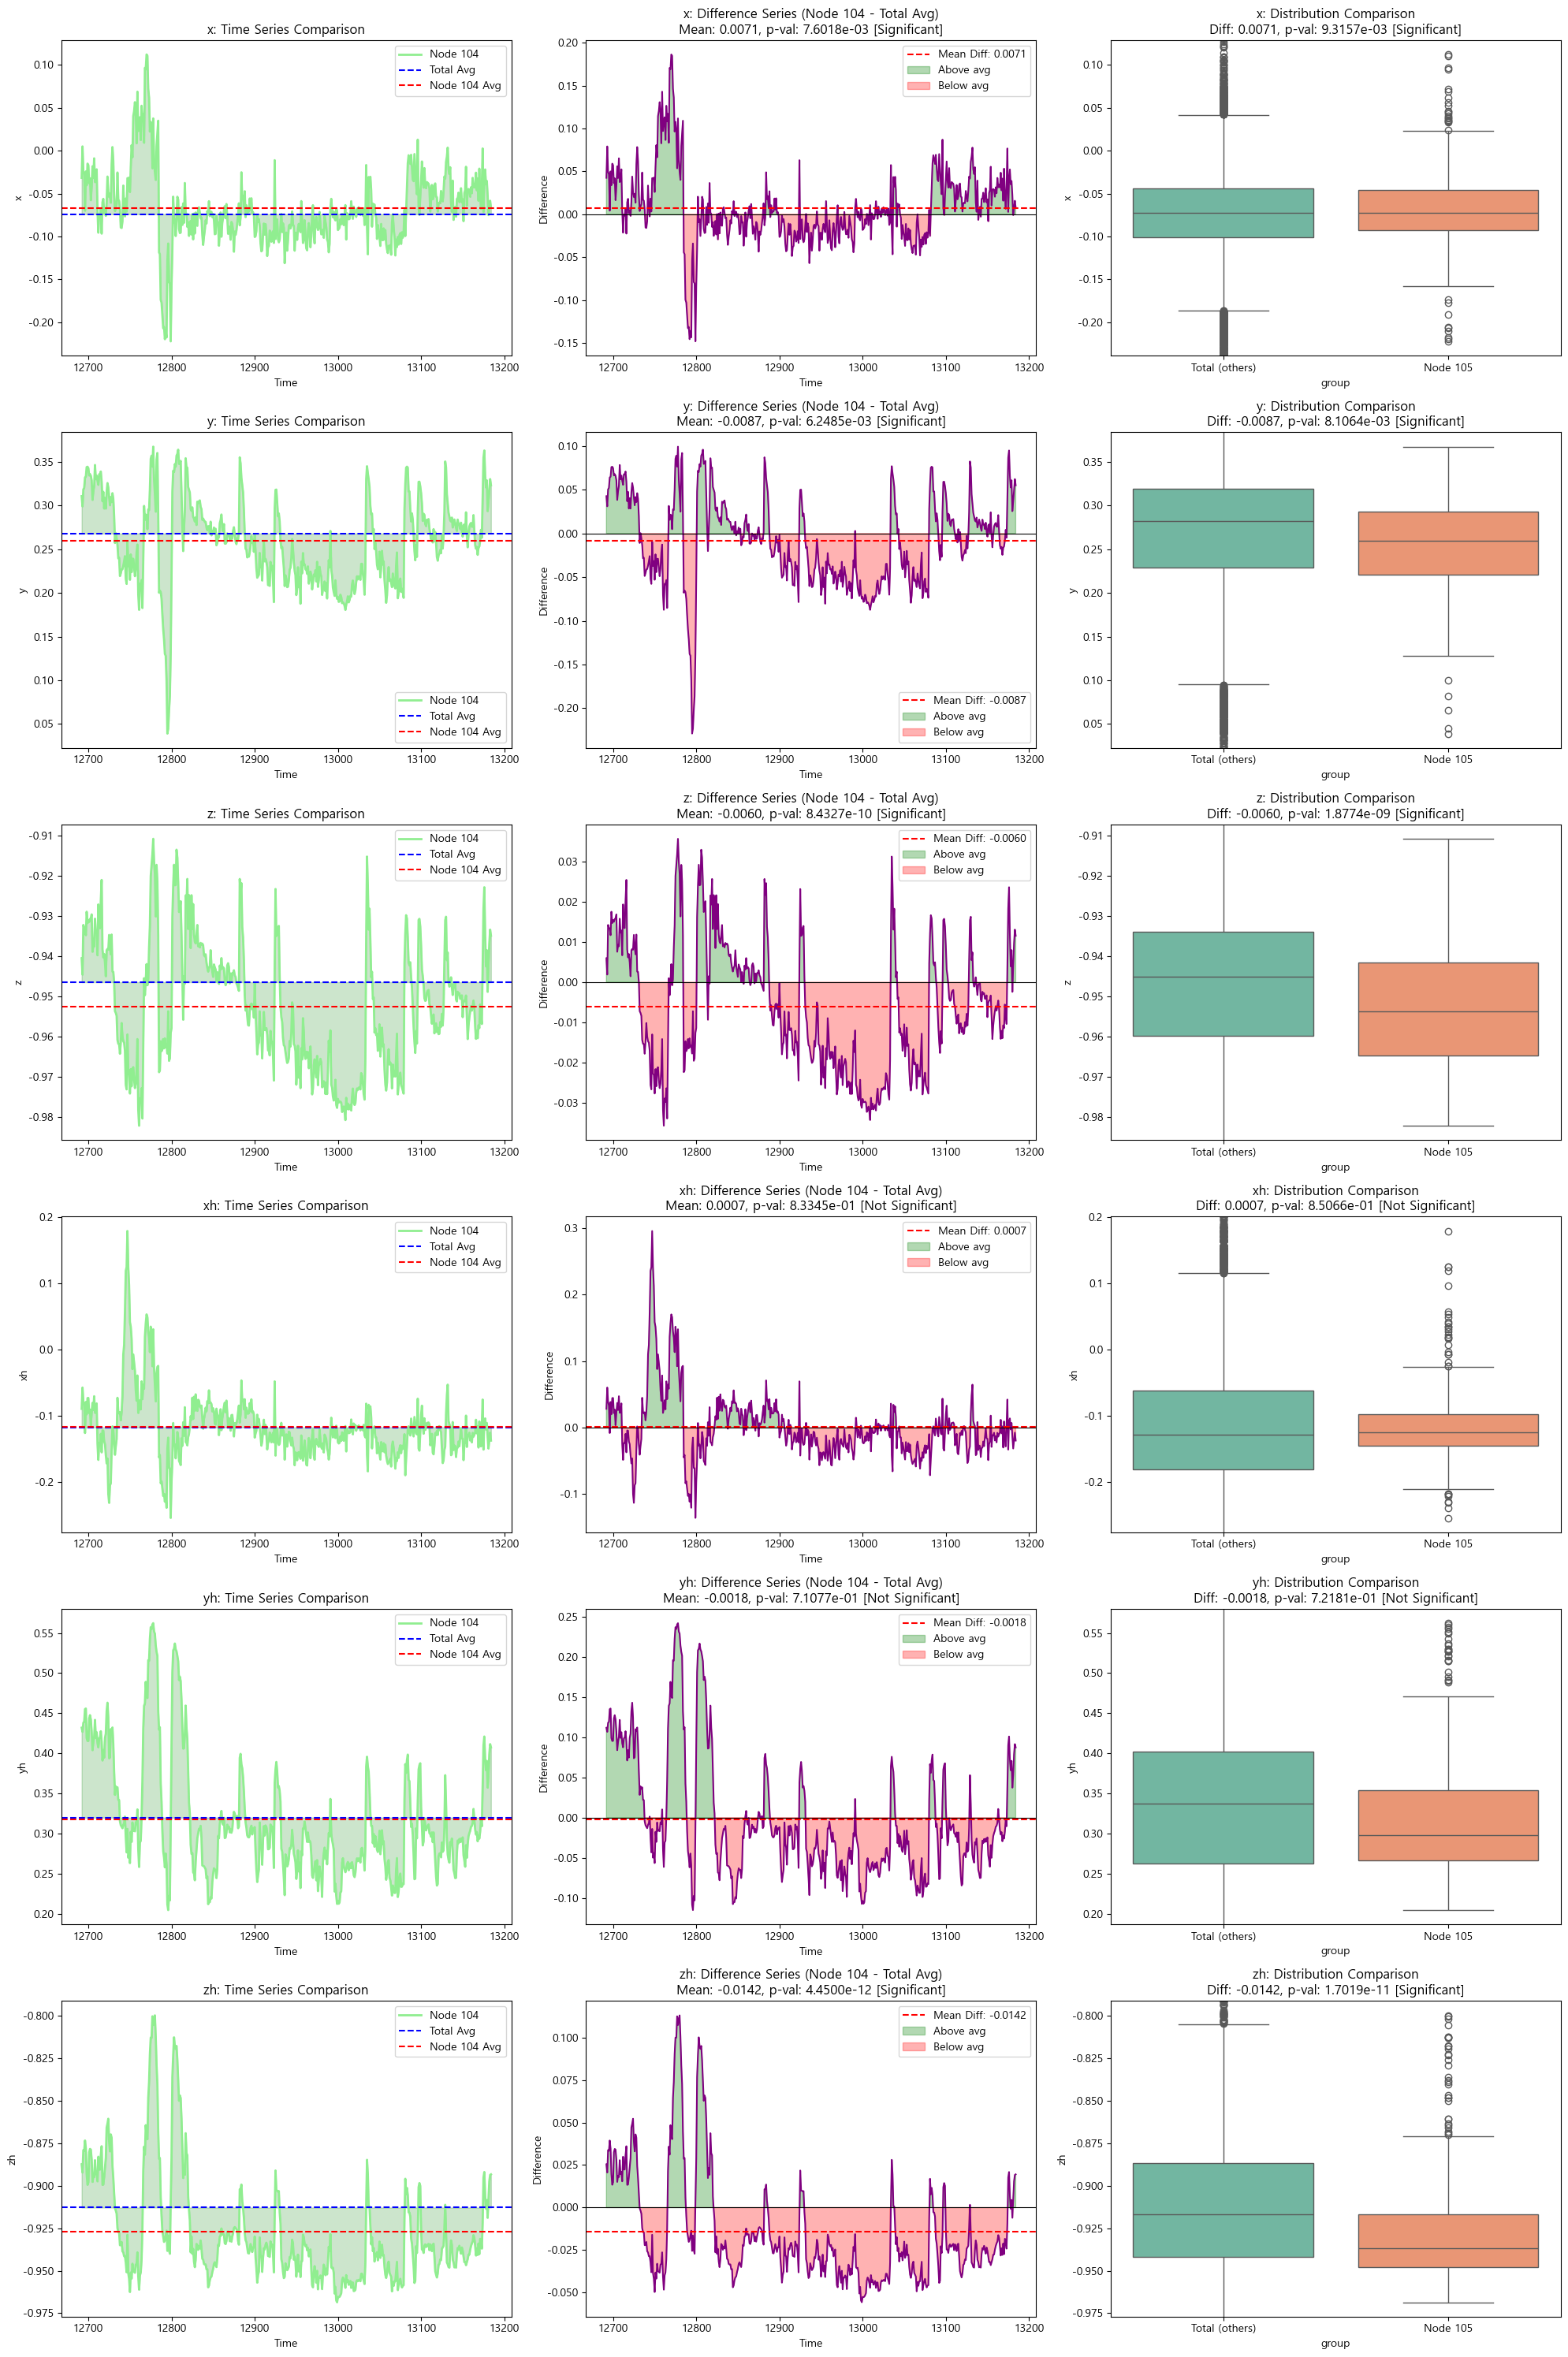

In [94]:
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(len(vision_plot_list), 3, figsize=(20, 5 * len(vision_plot_list)))

for i, target in enumerate(vision_plot_list):
  df = gz_df[[target]].copy()
  df['group'] = 1
  df_total = gz_df_total[[target]].copy()
  df_total['group'] = 0
  combined = pd.concat([df, df_total])
    
  model = smf.ols(f'{target} ~ group', data=combined).fit(
    cov_type='HAC', cov_kwds={'maxlags': 1}
  )
  nw_p_val = model.pvalues['group']
  nw_coef = model.params['group']
    
  diff_series = df[target].values - df_total[target].mean()
    
  diff_df = pd.DataFrame({'diff': diff_series, 'const': 1})
  diff_model = smf.ols('diff ~ 1', data=diff_df).fit(
    cov_type='HAC', cov_kwds={'maxlags': 1}
  )
  diff_p_val = diff_model.pvalues['Intercept']
  diff_mean = diff_model.params['Intercept']

  sns.lineplot(data=gz_df, x=gz_df.index, y=target, 
               ax=ax[i,0], color='lightgreen', label='Node 104', linewidth=2)
  ax[i,0].axhline(y=gz_df_total[target].mean(), 
                  color='blue', linestyle='--', linewidth=1.5, label='Total Avg')
  ax[i,0].axhline(y=gz_df[target].mean(), 
                  color='red', linestyle='--', linewidth=1.5, label='Node 104 Avg')
  ax[i,0].fill_between(gz_df.index, 
                       gz_df_total[target].mean(), 
                       gz_df[target],
                       alpha=0.2, color='green')
  ax[i,0].set_title(f"{target}: Time Series Comparison")
  ax[i,0].legend()
  ax[i,0].set_xlabel('Time')
    
  ax[i,1].plot(gz_df.index, diff_series, color='purple', linewidth=1.5)
  ax[i,1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
  ax[i,1].axhline(y=diff_mean, color='red', linestyle='--', linewidth=1.5, 
                  label=f'Mean Diff: {diff_mean:.4f}')
  ax[i,1].fill_between(gz_df.index, 0, diff_series, 
                       where=(diff_series > 0), alpha=0.3, color='green', 
                       label='Above avg')
  ax[i,1].fill_between(gz_df.index, 0, diff_series, 
                       where=(diff_series <= 0), alpha=0.3, color='red',
                       label='Below avg')
  significance = "Significant" if diff_p_val < 0.05 else "Not Significant"
  ax[i,1].set_title(f"{target}: Difference Series (Node 104 - Total Avg)\n"
                   f"Mean: {diff_mean:.4f}, p-val: {diff_p_val:.4e} [{significance}]")
  ax[i,1].legend()
  ax[i,1].set_xlabel('Time')
  ax[i,1].set_ylabel('Difference')
  
  sns.boxplot(data=combined, x='group', y=target, ax=ax[i,2], 
              hue='group', palette='Set2', legend=False)
  ax[i,2].set_xticks([0,1])
  ax[i,2].set_xticklabels(['Total (others)', 'Node 105'])
  
  ymin, ymax = ax[i,0].get_ylim()
  ax[i,2].set_ylim(ymin, ymax)
  
  significance_group = "Significant" if nw_p_val < 0.05 else "Not Significant"
  ax[i,2].set_title(f"{target}: Distribution Comparison\n"
                    f"Diff: {nw_coef:.4f}, p-val: {nw_p_val:.4e} [{significance_group}]")
  
plt.tight_layout()
plt.show()

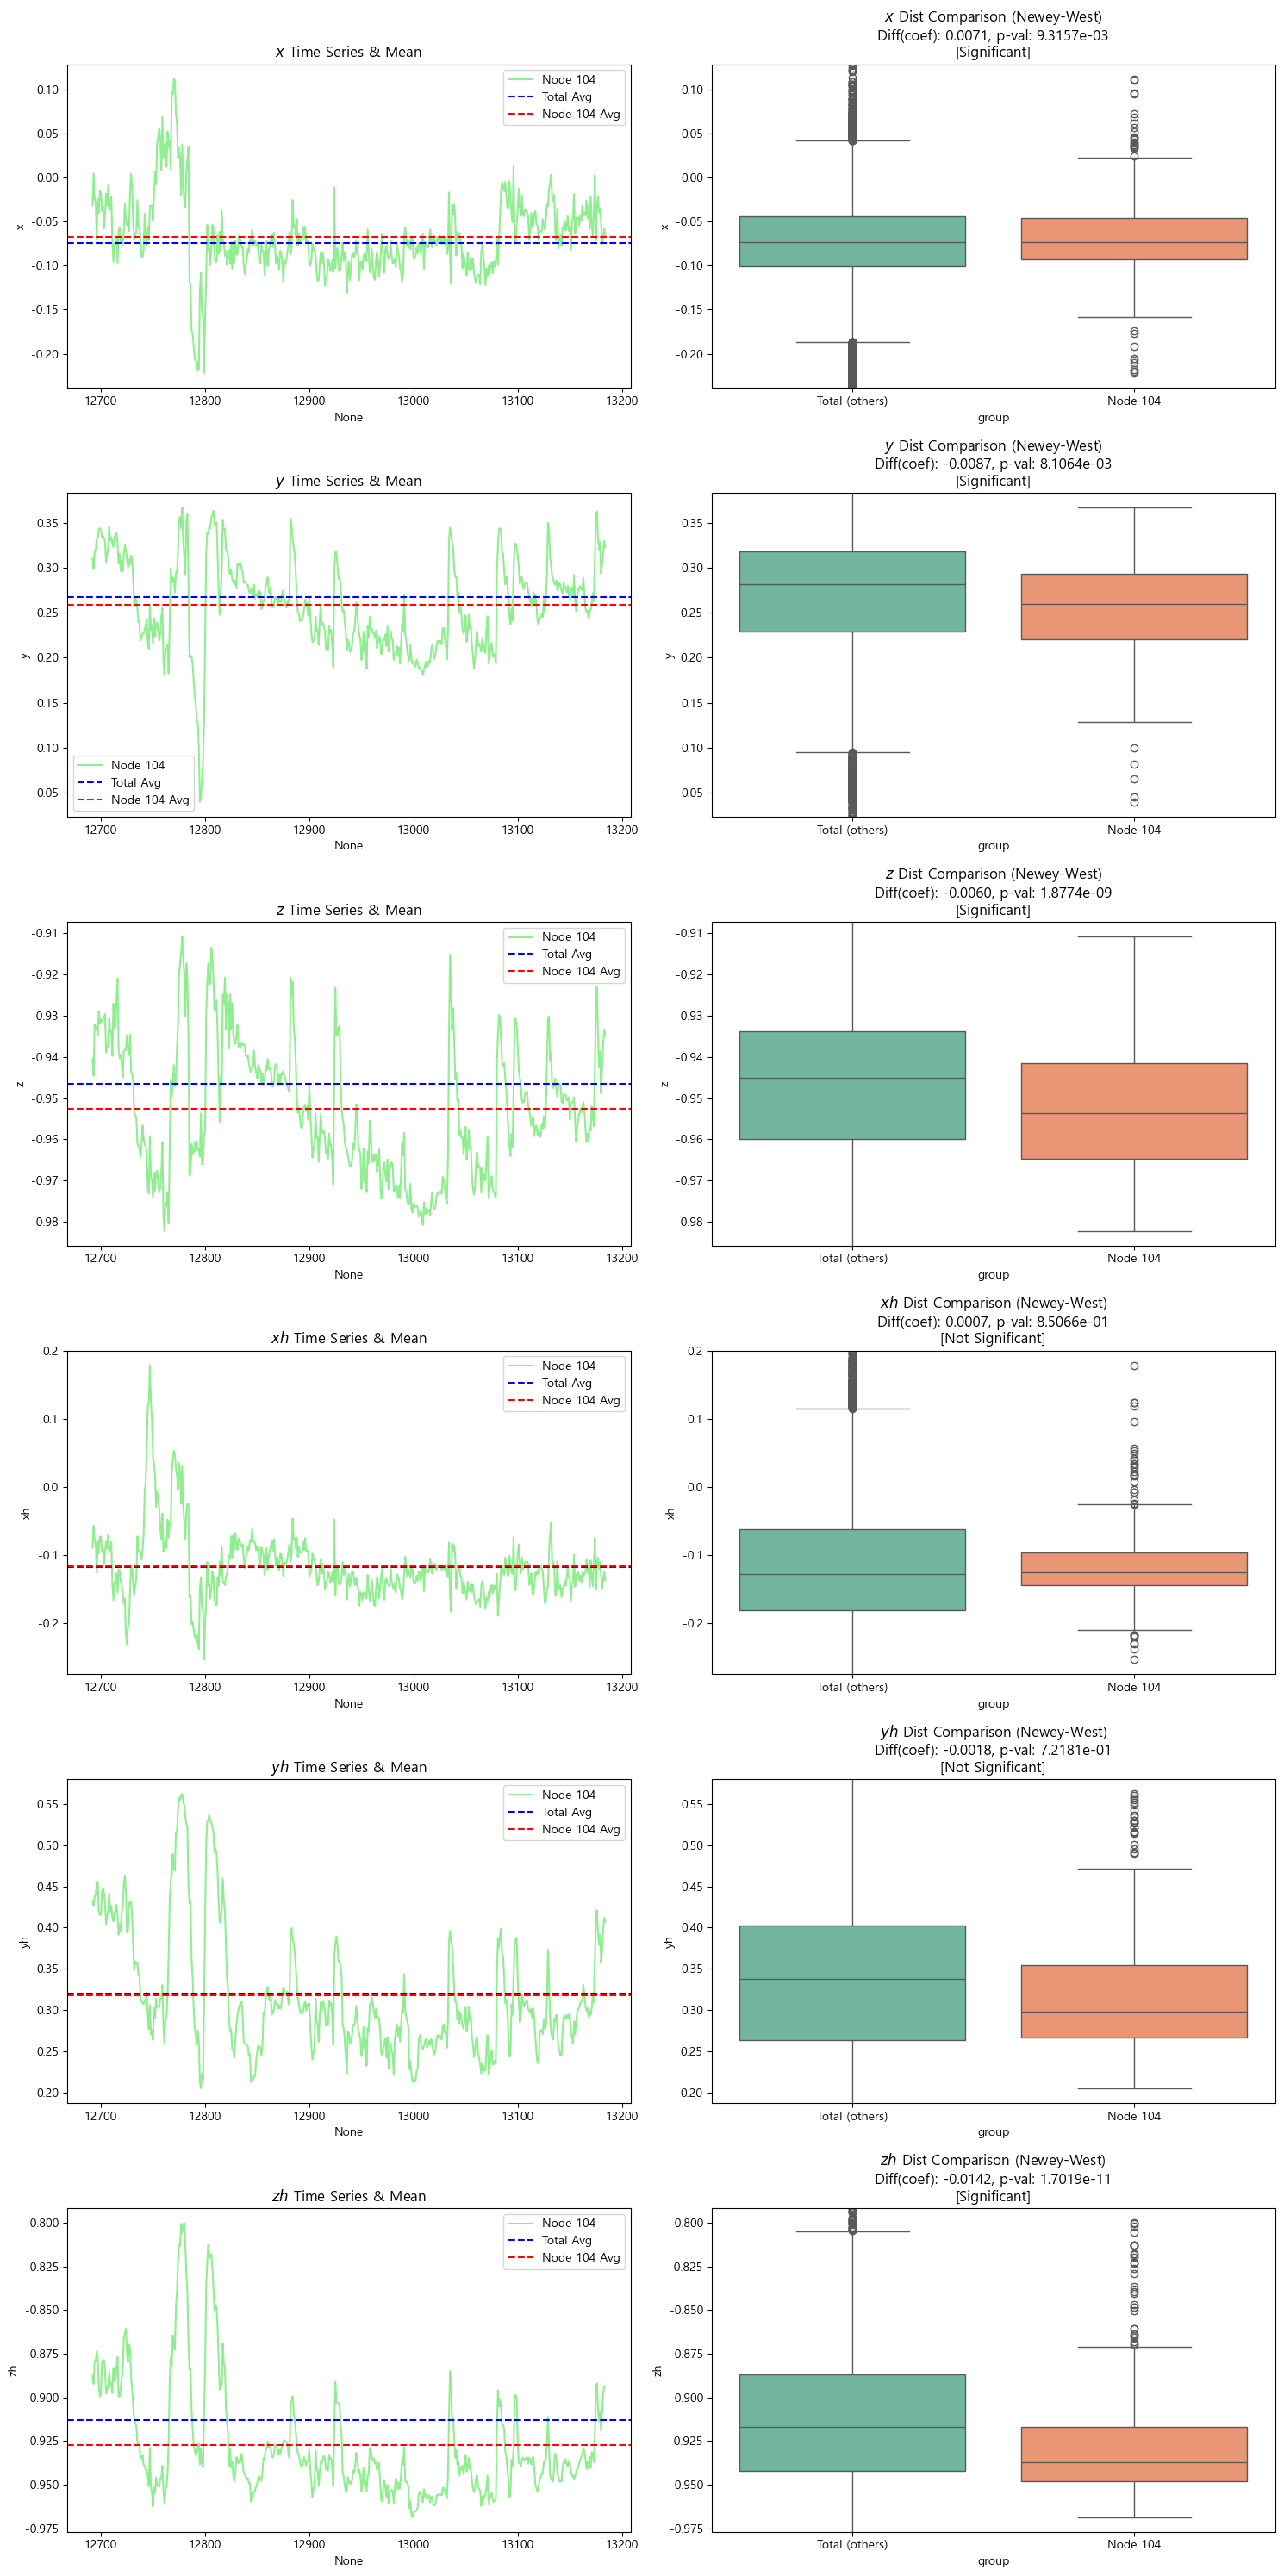

In [58]:
import statsmodels.formula.api as smf
import seaborn as sns

try:
  fig, ax = plt.subplots(len(vision_plot_list), 2, figsize=(15, 5 * len(vision_plot_list)))

  for i, target in enumerate(vision_plot_list):
    df = gz_df[[target]].copy(); df['group'] = 1
    df_total = gz_df_total[[target]].copy(); df_total['group'] = 0
    combined = pd.concat([df, df_total])

    model = smf.ols(f'{target} ~ group', data=combined).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

    nw_p_val = model.pvalues['group']  # Newey-West로 보정된 p-value
    nw_coef = model.params['group']    # 두 집단의 평균 차이 (beta1)

    sns.lineplot(data=gz_df, x=gz_df.index, y=target, ax=ax[i,0], color='lightgreen', label='Node 104')
    ax[i,0].axhline(y=gz_df_total[target].mean(), color='blue', linestyle='--', label='Total Avg')
    ax[i,0].axhline(y=gz_df[target].mean(), color='red', linestyle='--', label='Node 104 Avg')
    ax[i,0].set_title(f"${target}$ Time Series & Mean")
    ax[i,0].legend()

    sns.boxplot(data=combined, x='group', y=target, ax=ax[i,1], hue='group', palette='Set2', legend=False)
    ax[i,1].set_xticks([0,1])
    ax[i,1].set_xticklabels(['Total (others)', 'Node 104'])

    ymin, ymax = ax[i,0].get_ylim()
    ax[i,1].set_ylim(ymin, ymax)

    significance = "Significant" if nw_p_val < 0.05 else "Not Significant"
    ax[i,1].set_title(f"${target}$ Dist Comparison (Newey-West)\nDiff(coef): {nw_coef:.4f}, p-val: {nw_p_val:.4e}\n[{significance}]")

  plt.tight_layout()
  plt.show()
except Exception as e:
  print(e)

## Newey-West 표준오차 검정 결과

- 가설
    - GNN_Explainer로 산출된 중요한 프록시 노드 속 하위 멀티모달 노드의 특성 값은 일반적인 경우의 특성 값과 다를 것이다.

- 사용배경
    - DAIC-WOZ 속 Vision/Audio의 멀티모달 데이터는 시계열적 특성을 가졌기에 모든 표본이 독립적이지 않은 자기상관성을 가짐 = 오차가 자기상관성을 가짐
    - 평균의 차이를 보이기 위한 일반적인 t-검정이 적용되기 어려움
    - 자기상관성에 강건한 Newey-West 표준오차 검정 사용

- 결과
    - 104번 Vision 노드
        - 104 노드에서의 상/하 방향을 가리키는 y값이 p<0.05에서 일반적인 평균치보다 유의미하게 작음 -> 104번 노드 발화 시, 절대적인 시선이 아래쪽을 향하고 있음을 확인 가능
        - 아래쪽 시선은 우울증과 연관 있기에(출처 필요) 우울증 판별에 중요한 비전 노드를 적절히 사용했음을 알 수 있음
    - 105번 Audio 노드
        - 105번 노드에서 정규화 된 진폭 지수(NAQ)와 준개방 지수(QOQ) 값이 p<0.05에서 일반적인 평균치보다 유의미하게 작음
        - NAQ와 QOQ 및 우울증 사이에는 부적 상관관계가 존재하므로 NAQ/QOQ 값이 낮을수록 우울증에 가까움
        - 우울증에 가까운 특성을 가지고 있는 노드를 적절히 필터링 했음을 볼 수 있음

- 결론
    - 비록 102번의 text 노드 자체는 중요도가 크지 않지만, '이혼'과 관련된 발화를 이어나갈 때 프록시 노드를 적극 활용하여 멀티모달적 요소에서 중요한 특성을 적절히 추출하는 모습을 볼 수 있었음
